In [1]:
import numpy as np
import pybullet as p
import pandas as pd
import time
from robot_descriptions.loaders.pybullet import load_robot_description

pybullet build time: Nov 29 2024 16:26:49


In [2]:
p.connect(p.GUI)
p.setTimeStep(0.0001)
p.setGravity(0, 0, -9.81)

Version = 4.1 Metal - 76.3
Vendor = Apple
Renderer = Apple M1
b3Printf: Selected demo: Physics Server
startThreads creating 1 threads.
starting thread 0
started thread 0 
MotionThreadFunc thread started


In [3]:
from robot_descriptions import ur5_description
print(ur5_description.URDF_PATH)

/Users/theo/.cache/robot_descriptions/example-robot-data/robots/ur_description/urdf/ur5_robot.urdf


In [3]:
robot_id = load_robot_description('ur5_description', useFixedBase=True) 
joint_indices = [i for i in range(p.getNumJoints(robot_id)) if p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE]
for i in range(p.getNumJoints(robot_id)):
  print(p.getJointInfo(robot_id, i))
  print(p.getJointInfo(robot_id, i)[2] == p.JOINT_REVOLUTE)

immovable_joints = [6, 8]
wrist3_joint = 6
eff_idx = 7
pendulum_joint_idx = 8
print("End effector joint: ", eff_idx)
print("Revolute joints: ", joint_indices)

(0, b'world_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'base_link', (0.0, 0.0, 0.0), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), -1)
False
(1, b'shoulder_pan_joint', 0, 7, 6, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'shoulder_link', (0.0, 0.0, 1.0), (0.0, 0.0, 0.089159), (0.0, 0.0, 0.0, 1.0), 0)
True
(2, b'shoulder_lift_joint', 0, 8, 7, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 150.0, 3.15, b'upper_arm_link', (0.0, 1.0, 0.0), (0.0, 0.13585, 0.0), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 1)
True
(3, b'elbow_joint', 0, 9, 8, 1, 0.0, 0.0, -3.14159265359, 3.14159265359, 150.0, 3.15, b'forearm_link', (0.0, 1.0, 0.0), (0.0, -0.1197, 0.14499999999999996), (0.0, 0.0, 0.0, 1.0), 2)
True
(4, b'wrist_1_joint', 0, 10, 9, 1, 0.0, 0.0, -6.28318530718, 6.28318530718, 28.0, 3.2, b'wrist_1_link', (0.0, 1.0, 0.0), (0.0, 0.0, 0.14225), (0.0, -0.7071067811848163, 0.0, 0.7071067811882787), 3)
True
(5, b'wrist_2_joint', 0, 11, 10, 1, 0.0, 0.0, -6.28318530718, 6.283185307

# Inverse kinematics with preferred positions

In [5]:
#lower limits for null space
ll = [3.14 / 18 * x for x in [-36, 3.5, -6.5, 1.5, -4, 17.5, 0]]
#upper limits for null space
ul = [3.14 / 18 * x for x in [36,  4.5, -5.5, 4.5,  4, 17.5, 0]]
#joint ranges for null space
jr = [3.14 / 18  * x for x in [72,    1,    1,   3,  8,    0, 0]]
#restposes for null space
rp = [3.14 / 18 * x for x in [0,     4,   -6,   3,  0, 17.5, 0]]

print(ll)
print(ul)
print(jr)
print(rp)

def smoothInverseKinematics(robot_id, eff_idx, target_pos):
  current_positon = p.getLinkState(robot_id, eff_idx)[0]
  return p.calculateInverseKinematics(
    robot_id,
    eff_idx,
    target_pos,
    lowerLimits = ll,
    upperLimits = ul,
    jointRanges = jr,
    restPoses   = rp,
    solver=420,
    maxNumIterations=20,
    residualThreshold=.01
  )

[-6.28, 0.6105555555555556, -1.133888888888889, 0.2616666666666667, -0.6977777777777778, 3.052777777777778, 0.0]
[6.28, 0.785, -0.9594444444444445, 0.785, 0.6977777777777778, 3.052777777777778, 0.0]
[12.56, 0.17444444444444446, 0.17444444444444446, 0.5233333333333334, 1.3955555555555557, 0.0, 0.0]
[0.0, 0.6977777777777778, -1.0466666666666669, 0.5233333333333334, 0.0, 3.052777777777778, 0.0]


# Disable default motor control

In [6]:
for i in joint_indices:
    p.setJointMotorControl2(
        bodyUniqueId=robot_id,
        jointIndex=i,
        controlMode=p.VELOCITY_CONTROL,
        force=0  # Disable motor forces
    )

# Feedback and Stabilization

In [7]:
def pd_control(robot_id, q_desired, v_desired, Kp, Kd):
  joint_states = p.getJointStates(robot_id, joint_indices)
  q_measured = np.array([state[0] for state in joint_states])
  v_measured = np.array([state[1] for state in joint_states])
  position_error = q_desired - q_measured
  velocity_error = v_desired - v_measured
  
  tau = Kp * position_error + Kd * velocity_error
  # add gravity compensation
  tau += np.array(p.calculateInverseDynamics(robot_id, q_measured.tolist(), [0] * len(joint_indices), [0] * len(joint_indices)))
  for i in range(len(joint_indices)):
    if joint_indices[i] in immovable_joints: # ensure pendulum and wrist 3 joint is commanded with zero torque
      tau[i] = 0
  return tau

Kp = 100 * np.ones_like(joint_indices)
Kd = 5 * np.ones_like(joint_indices)

def control_to_desired_configuration(robot_id, q_desired, v_desired=None, max_steps=5000, sleep=None):
  if v_desired is None:
    v_desired = np.zeros_like(q_desired)
  for step in range(max_steps):  # Simulation steps
    torques = pd_control(robot_id, q_desired, v_desired, Kp, Kd).tolist()
    p.setJointMotorControlArray(
      bodyUniqueId=robot_id,
      jointIndices=joint_indices,
      controlMode=p.TORQUE_CONTROL,
      forces=torques
    )
    p.stepSimulation()
    if sleep is not None:
      time.sleep(sleep)
    

# Resetting to balanced pose

In [8]:
rest_pose_balancing = [np.pi / 18 * x for x in [0, 4, -6, 3, 0, 17.3, 0]]
def reset_to_balancing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=-rest_pose_balancing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
      )

In [9]:
rest_pose_swing = [np.pi / 18 * x for x in [0, 4, -6, 3, 0, 17.3, 18]]
def reset_to_swing_pose(robot_id):
  for i in range(len(joint_indices)): 
    p.resetJointState(robot_id, joint_indices[i], targetValue=-rest_pose_swing[i], targetVelocity=0)
    p.setJointMotorControl2(
          bodyUniqueId=robot_id,
          jointIndex=joint_indices[i],
          controlMode=p.VELOCITY_CONTROL,
          force=0  # Disable motor forces
      )

In [10]:
reset_to_balancing_pose(robot_id)

In [11]:
print(p.getLinkState(robot_id, eff_idx))

((0.7105991188452455, 0.19145000000000006, 0.13497427907824033), (-0.009255741794926584, -0.009255741794971906, 0.7070462016313909, 0.7070462016348529), (0.0, 0.0, 0.0), (0.0, 0.0, 0.0, 1.0), (0.7105991244316101, 0.19144999980926514, 0.13497428596019745), (-0.00925574079155922, -0.00925574079155922, 0.7070462107658386, 0.7070462107658386))


In [12]:
p.calculateInverseKinematics(robot_id, eff_idx, (0.7105991188452455, 0.19145000000000006, 0.13497427907824033))

(3.4187670006900682e-18,
 -0.6981317007977319,
 1.0471975511965974,
 -0.5235987755982988,
 3.2627810165066864e-17,
 -2.993239667170275,
 0.0)

# Moving end-effector along a horizontal line

## Forward movement

In [13]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point =p.getLinkState(robot_id, eff_idx)[0] #np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  # [x, y, z] in 3D space
direction_vector = np.array([+0.3, 0, 0])  # Direction along X-axis (horizontal)
target_positions = start_point + np.linspace(0, 1, num=10)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

[0.69310873 0.19145    0.25235053] [0.99310873 0.19145    0.25235053]
(7, b'ee_fixed_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'ee_link', (0.0, 0.0, 0.0), (0.0, 0.0823, 0.0), (0.0, 0.0, -0.7071067811848163, 0.7071067811882787), 6)


## Backward movement

In [14]:
# Define the start point and direction of the line
reset_to_balancing_pose(robot_id)
start_point = p.getLinkState(robot_id, eff_idx)[0] #np.array([0.7105991188452455, 0.19145000000000006, 0.13497427907824033])  # [x, y, z] in 3D space
direction_vector = np.array([-0.3, 0, 0])  # Direction along X-axis (horizontal)
target_positions = start_point + np.linspace(0, 1, num=10)[:, np.newaxis] * direction_vector[np.newaxis, :]
print(target_positions[0], target_positions[-1])
print(p.getJointInfo(robot_id, eff_idx))

time.sleep(1)
for target in target_positions:
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(1 / 1000.)

[0.69310873 0.19145    0.25235053] [0.39310873 0.19145    0.25235053]
(7, b'ee_fixed_joint', 4, -1, -1, 0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, b'ee_link', (0.0, 0.0, 0.0), (0.0, 0.0823, 0.0), (0.0, 0.0, -0.7071067811848163, 0.7071067811882787), 6)


In [15]:
reset_to_balancing_pose(robot_id)
start_point = p.getLinkState(robot_id, eff_idx)[0]
left_point = start_point  - np.array([0.3, 0, 0])
right_point = start_point + np.array([0.3, 0, 0])

time.sleep(2)
for i in range(10):
  if i % 2 == 0:
    target = left_point
  else:
    target = right_point
  joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
  control_to_desired_configuration(robot_id, joint_angles)
  time.sleep(0.01)

# Balancing the pendulum

In [39]:
from tqdm import tqdm

class EnvRealistic:
  axis_vector = np.array([0.1, 0, 0])
  action_space = "Continuous [0, 1]"
  def __init__(self, TIME_HORIZON=1000, sleep=None,swing = False ):
    self.TIME_HORIZON = TIME_HORIZON
    self.sleep=sleep
    self.swing= swing
    self.reset()
    

  def rand_action(self):
    return np.random.rand() * 2 - 1

  def convert_3d_coords_to_line_position(self, world_pos):
    return world_pos[0] - self.start_point[0]

  def convert_3d_velo_to_line_velo(self, world_vel):
    return np.dot(EnvRealistic.axis_vector, world_vel)

  def get_state(self):
    (world_pos, _, _, _, _, _, world_velo, _) = p.getLinkState(robot_id, eff_idx, computeLinkVelocity=True)
    x = self.convert_3d_coords_to_line_position(np.array(world_pos))
    x_dot = self.convert_3d_velo_to_line_velo(np.array(world_velo))
    theta = p.getJointState(robot_id, wrist3_joint)[0] - self.initial_theta
    theta_dot = p.getJointState(robot_id, wrist3_joint)[1]
  
    return (x, x_dot, theta, theta_dot)

  def reset(self):
    """ 
    Returns state
    """
    self.timestep = 0
    reset_to_balancing_pose(robot_id)
    if self.swing :
      reset_to_swing_pose(robot_id)
    self.initial_theta = p.getJointState(robot_id, wrist3_joint)[0]
    self.start_point = p.getLinkState(robot_id, eff_idx)[0]
    self.left_point = self.start_point - 3 * EnvRealistic.axis_vector
    self.right_point = self.start_point  + 3 * EnvRealistic.axis_vector
    return (0, 0, 0, 0)
  
  def step(self, action):
    """
    Returns tuple (state, dead, truncated)
    """
    if action < -1 or action > 1:
      raise Exception("Action not in range [-1, 1]")
    current_position = p.getLinkState(robot_id, eff_idx)[0]
    target = self.start_point - action * EnvRealistic.axis_vector
    
      
    joint_angles = p.calculateInverseKinematics(robot_id,eff_idx,target)
    control_to_desired_configuration(robot_id, joint_angles, max_steps=100, sleep=self.sleep)
    (x, x_dot, theta, theta_dot) = self.get_state()
    self.timestep += 1
    dead = False
    truncated = False
    #if np.abs(theta) > 0.25:
      #print(theta, " theta DEAD")
      #dead = True
    if x + self.start_point[0] < self.left_point[0] or x + self.start_point[0] > self.right_point[0]:
      print(x, " x DEAD")
      dead = True
    #if self.timestep == self.TIME_HORIZON:
    #  truncated = True
 
    return ((x, x_dot, theta, theta_dot), dead, truncated)


def generate_sample_of_system_dynamics_realistic(env, nb_samples):
  samples = []
  s = env.reset()
  for _ in tqdm(range(nb_samples)):
    a = env.rand_action()
    next_s, dead, trunc = env.step(a)
    samples.append({
      'x': s[0], 
      'x_dot': s[1], 
      'theta': s[2], 
      'theta_dot': s[3], 
      'u': a, # mapping inputs to {-1, 1} rather than {0, 1} is important, because otherwise the linear regression needs a non-zero constant to fit well
      'evolution_x': next_s[0], 
      'evolution_x_dot': next_s[1], 
      'evolution_theta': next_s[2],
      'evolution_theta_dot': next_s[3]})
    if dead or trunc:
      s = env.reset()
    else:
      s = next_s
  return pd.DataFrame(samples)

In [18]:
env = EnvRealistic(sleep=0.0001)
samples = generate_sample_of_system_dynamics_realistic(env, 1000)

  0%|          | 1/1000 [00:00<07:39,  2.17it/s]

z = 0.2525515936114975
-0.0005902245770247339
-0.006661330494119433


  0%|          | 2/1000 [00:00<08:24,  1.98it/s]

z = 0.2529515648742796
-0.001789336756935822
-0.017548920174818128


  0%|          | 3/1000 [00:01<08:55,  1.86it/s]

z = 0.25314113937451377
-0.0024472412766793905
-0.01805277948848316


  0%|          | 4/1000 [00:02<08:29,  1.96it/s]

z = 0.2539667261640223
-0.004919076535026989
-0.03925112158679933


  0%|          | 5/1000 [00:02<08:04,  2.06it/s]

z = 0.2530606763717718
-0.0026066830876080305
0.0057789648024630935


  1%|          | 6/1000 [00:02<07:49,  2.12it/s]

z = 0.2538497117243103
-0.004963576558907112
-0.01795442870978803


  1%|          | 7/1000 [00:03<08:03,  2.05it/s]

z = 0.25459095456302494
-0.00738984546587651
-0.03072062409398968


  1%|          | 8/1000 [00:04<08:23,  1.97it/s]

z = 0.25570952005284125
-0.011043985558955693
-0.0528252018737686


  1%|          | 9/1000 [00:04<08:04,  2.05it/s]

z = 0.255188346646442
-0.010294795456976424
-0.01458929796861086


  1%|          | 10/1000 [00:04<07:50,  2.10it/s]

z = 0.25405210825233476
-0.006960240266785878
0.04081287639123665


  1%|          | 11/1000 [00:05<07:40,  2.15it/s]

z = 0.2545132807037881
-0.008363232588185832
0.025915819009588725


  1%|          | 12/1000 [00:05<07:34,  2.17it/s]

z = 0.25567859239692126
-0.012179129390633037
-0.005134547588599325


  1%|▏         | 13/1000 [00:06<07:29,  2.20it/s]

z = 0.2562810776921847
-0.014684694318109037
-0.007045887072031798


  1%|▏         | 14/1000 [00:06<07:03,  2.33it/s]

z = 0.25533444843664854
-0.012321296790420377
0.049187642975439316


  2%|▏         | 15/1000 [00:07<07:09,  2.29it/s]

z = 0.25471167368015785
-0.010224425908467505
0.0841902571164847


  2%|▏         | 16/1000 [00:07<07:35,  2.16it/s]

z = 0.25500126415895386
-0.011143292129972782
0.07678825234789832


  2%|▏         | 17/1000 [00:08<07:28,  2.19it/s]

z = 0.253950073765828
-0.007423865318599843
0.1330016384228433


  2%|▏         | 18/1000 [00:08<07:33,  2.16it/s]

z = 0.2539820228699792
-0.007408661507478986
0.13151107642952736


  2%|▏         | 19/1000 [00:09<09:03,  1.81it/s]

z = 0.2542424829139654
-0.008326695298265352
0.12633480157507448


  2%|▏         | 20/1000 [00:09<08:59,  1.82it/s]

z = 0.2544077509861228
-0.009007050208859835
0.12975765283847923


  2%|▏         | 21/1000 [00:10<08:28,  1.93it/s]

z = 0.25514823522183383
-0.011739570217198292
0.1121459373146741


  2%|▏         | 22/1000 [00:10<08:09,  2.00it/s]

z = 0.25609867222128685
-0.015428640577943686
0.09444579572770656


  2%|▏         | 23/1000 [00:11<07:54,  2.06it/s]

z = 0.2566096324514261
-0.01801292627417206
0.09796118470750798


  2%|▏         | 24/1000 [00:11<07:43,  2.10it/s]

z = 0.255542495953569
-0.015132035037146219
0.16604859035316533


  2%|▎         | 25/1000 [00:12<07:39,  2.12it/s]

z = 0.25541744347926343
-0.014834416051198063
0.1823441921338867


  3%|▎         | 26/1000 [00:12<07:58,  2.04it/s]

z = 0.2555665429630691
-0.015571396789339942
0.1860682093778826


  3%|▎         | 27/1000 [00:13<07:45,  2.09it/s]

z = 0.25475740090849985
-0.012664105684991878
0.2360833775295093


  3%|▎         | 28/1000 [00:13<07:35,  2.13it/s]

z = 0.25365615278648834
-0.008012580227877097
0.29508953188417053


  3%|▎         | 29/1000 [00:13<07:36,  2.13it/s]

z = 0.25373315157876936
-0.008374465773878015
0.2839459097919069


  3%|▎         | 30/1000 [00:14<09:27,  1.71it/s]

z = 0.2536102199011342
-0.007982472791357442
0.2937585555340875


  3%|▎         | 31/1000 [00:15<09:25,  1.71it/s]

z = 0.2529534655152899
-0.0053659332051696484
0.3312653251772403


  3%|▎         | 32/1000 [00:16<11:02,  1.46it/s]

z = 0.25271259935834217
-0.004501123465421419
0.34091284033119607


  3%|▎         | 33/1000 [00:17<11:20,  1.42it/s]

z = 0.25236007671288974
-0.003195438040910603
0.3587347565699993


  3%|▎         | 34/1000 [00:17<11:15,  1.43it/s]

z = 0.2529731807787894
-0.005849646389683327
0.3303611515220317


  4%|▎         | 35/1000 [00:18<11:49,  1.36it/s]

z = 0.2526463511704272
-0.004794377969208563
0.3616094753765874


  4%|▎         | 36/1000 [00:19<11:36,  1.38it/s]

z = 0.25297668654068267
-0.006308001733937751
0.3539808380639198


  4%|▎         | 37/1000 [00:20<12:05,  1.33it/s]

z = 0.25203526104017354
-0.0025428718322833
0.4174270913128809


  4%|▍         | 38/1000 [00:20<11:04,  1.45it/s]

z = 0.25140123953845217
0.0001657251416271599
0.4514882344973908


  4%|▍         | 39/1000 [00:21<10:24,  1.54it/s]

z = 0.25112728372732646
0.0011288371840649791
0.4596577263071963


  4%|▍         | 40/1000 [00:21<09:23,  1.70it/s]

z = 0.25113296318260186
0.0008468438463615779
0.4554874153347943


  4%|▍         | 41/1000 [00:22<08:47,  1.82it/s]

z = 0.2504939371764225
0.0036087805843290077
0.49345911785363844


  4%|▍         | 42/1000 [00:22<09:50,  1.62it/s]

z = 0.24949443742837354
0.008241512763134895
0.546891557561099


  4%|▍         | 43/1000 [00:23<09:32,  1.67it/s]

z = 0.24989222490396074
0.005718609881731895
0.5067707051631578


  4%|▍         | 44/1000 [00:23<08:53,  1.79it/s]

z = 0.2506557752862691
0.00242063646519175
0.4769565753486898


  4%|▍         | 45/1000 [00:24<08:25,  1.89it/s]

z = 0.25181494188520365
-0.0022199626902260627
0.44195203437726815


  5%|▍         | 46/1000 [00:24<08:02,  1.98it/s]

z = 0.253042644648582
-0.007148131698957894
0.41492341065743116


  5%|▍         | 47/1000 [00:25<07:47,  2.04it/s]

z = 0.25303355242569014
-0.007385339149811765
0.4497298287758502


  5%|▍         | 48/1000 [00:25<07:35,  2.09it/s]

z = 0.25238876945041855
-0.0042572450442142085
0.5100109673057276


  5%|▍         | 49/1000 [00:26<07:27,  2.12it/s]

z = 0.25182501009773417
-0.0009948778486505994
0.55328392783663


  5%|▌         | 50/1000 [00:26<07:20,  2.16it/s]

z = 0.25124622104806116
0.0024002534789583363
0.587453707247143


  5%|▌         | 51/1000 [00:27<07:19,  2.16it/s]

z = 0.2511235870444843
0.0028069588492652953
0.5791743848290184


  5%|▌         | 52/1000 [00:28<10:35,  1.49it/s]

z = 0.2517924816007204
-0.000688997606002717
0.5325100376859143


  5%|▌         | 53/1000 [00:28<10:09,  1.55it/s]

z = 0.2522816114114744
-0.0026955513007911325
0.520220789554574


  5%|▌         | 54/1000 [00:29<10:38,  1.48it/s]

z = 0.253055630921778
-0.0060647701537063226
0.49322200372764546


  6%|▌         | 55/1000 [00:30<10:32,  1.49it/s]

z = 0.253318013050591
-0.007014090101785331
0.5010126240371235


  6%|▌         | 56/1000 [00:30<09:29,  1.66it/s]

z = 0.253141921402497
-0.0056751835365640435
0.5289101118138421


  6%|▌         | 57/1000 [00:31<08:44,  1.80it/s]

z = 0.2538118434332475
-0.008833583202314754
0.4939135854211195


  6%|▌         | 58/1000 [00:31<07:53,  1.99it/s]

z = 0.25360170774524005
-0.00724565989284387
0.526721411688098


  6%|▌         | 59/1000 [00:32<07:57,  1.97it/s]

z = 0.25311007748948666
-0.003683449079733614
0.5691250894865403


  6%|▌         | 60/1000 [00:32<07:38,  2.05it/s]

z = 0.253369261461399
-0.0051331062317897524
0.5401378117817276


  6%|▌         | 61/1000 [00:32<07:06,  2.20it/s]

z = 0.2533209351046959
-0.004356782051715413
0.5477548098393009


  6%|▌         | 62/1000 [00:33<07:04,  2.21it/s]

z = 0.2534070025553696
-0.004548481127413351
0.5388211427727969


  6%|▋         | 63/1000 [00:33<07:03,  2.21it/s]

z = 0.2539255279227369
-0.007252649218725038
0.5028886444480426


  6%|▋         | 64/1000 [00:34<07:01,  2.22it/s]

z = 0.25363770728562274
-0.004845807688612758
0.5377452214973477


  6%|▋         | 65/1000 [00:34<07:28,  2.08it/s]

z = 0.2540689765997849
-0.007192954621973557
0.503114637196317


  7%|▋         | 66/1000 [00:35<07:22,  2.11it/s]

z = 0.2538958535458137
-0.005412002474925459
0.5279746758046089


  7%|▋         | 67/1000 [00:35<07:14,  2.15it/s]

z = 0.25446145623236427
-0.008637640244224976
0.4838223518058939


  7%|▋         | 68/1000 [00:36<07:07,  2.18it/s]

z = 0.25507886736699675
-0.011819175069996524
0.4543001925375297


  7%|▋         | 69/1000 [00:36<07:03,  2.20it/s]

z = 0.25587093220089707
-0.016058143011320913
0.41747998222006444


  7%|▋         | 70/1000 [00:36<07:01,  2.21it/s]

z = 0.2557377483612034
-0.014892775974397199
0.4509059996545567


  7%|▋         | 71/1000 [00:37<07:00,  2.21it/s]

z = 0.25537120985137685
-0.011453672710575513
0.4934053932709518


  7%|▋         | 72/1000 [00:37<06:57,  2.22it/s]

z = 0.25543780195095395
-0.011742211560634708
0.4763059044639116


  7%|▋         | 73/1000 [00:38<06:56,  2.23it/s]

z = 0.25561767449306366
-0.012823040118277174
0.4547511666232399


  7%|▋         | 74/1000 [00:38<07:24,  2.08it/s]

z = 0.2561045222335522
-0.016008423722977505
0.4139627101022123


  8%|▊         | 75/1000 [00:39<08:15,  1.87it/s]

z = 0.25681724303036046
-0.02051606333927858
0.3698943690052885


  8%|▊         | 76/1000 [00:39<07:56,  1.94it/s]

z = 0.2571066396513758
-0.022447582107300024
0.3650776506081057


  8%|▊         | 77/1000 [00:40<07:35,  2.03it/s]

z = 0.2570677238939968
-0.022057523771250698
0.38025295305694895


  8%|▊         | 78/1000 [00:40<07:22,  2.08it/s]

z = 0.25743970792494686
-0.02479880970988846
0.3491013327772252


  8%|▊         | 79/1000 [00:41<07:13,  2.13it/s]

z = 0.25773143674395227
-0.027099330656627618
0.3306184015530226


  8%|▊         | 80/1000 [00:41<06:46,  2.26it/s]

z = 0.25771763745709264
-0.027208898478981114
0.33723246783455635


  8%|▊         | 81/1000 [00:42<06:45,  2.27it/s]

z = 0.2580074840349459
-0.02976355776134365
0.30856026344006504


  8%|▊         | 82/1000 [00:42<06:44,  2.27it/s]

z = 0.2577936681649974
-0.028311948955497712
0.3325240348321008


  8%|▊         | 83/1000 [00:43<06:46,  2.26it/s]

z = 0.2579232096631456
-0.02981774080463684
0.30953741781891775


  8%|▊         | 84/1000 [00:43<06:45,  2.26it/s]

z = 0.25764299168418214
-0.02755048527738968
0.33605002725287836


  8%|▊         | 85/1000 [00:43<06:45,  2.25it/s]

z = 0.2574591042676482
-0.02628131394121025
0.337859367396682


  9%|▊         | 86/1000 [00:44<06:50,  2.23it/s]

z = 0.2571120579149644
-0.02325980123702298
0.3581766013190574


  9%|▊         | 87/1000 [00:44<07:33,  2.01it/s]

z = 0.2568934134274606
-0.022297483601209644
0.3472644953107471


  9%|▉         | 88/1000 [00:45<07:59,  1.90it/s]

z = 0.2569857582620296
-0.024489328830019086
0.306660833126564


  9%|▉         | 89/1000 [00:46<08:48,  1.72it/s]

z = 0.2567134531464334
-0.022486448104674484
0.3287027110324011


  9%|▉         | 90/1000 [00:46<08:38,  1.76it/s]

z = 0.2562495069079912
-0.01807028573945746
0.3682926670959956


  9%|▉         | 91/1000 [00:47<08:04,  1.88it/s]

z = 0.25584961685434354
-0.015543880919318909
0.37344393916575647


  9%|▉         | 92/1000 [00:47<08:29,  1.78it/s]

z = 0.2553415885453597
-0.01157789672960119
0.3959120724077087


  9%|▉         | 93/1000 [00:48<08:06,  1.87it/s]

z = 0.25494079892714844
-0.010508619699110544
0.37989113443466943


  9%|▉         | 94/1000 [00:48<08:07,  1.86it/s]

z = 0.25489804920574277
-0.012785112111044161
0.3356373015912916


 10%|▉         | 95/1000 [00:49<07:45,  1.94it/s]

z = 0.25456184180561636
-0.009850051499605161
0.3687203430366929


 10%|▉         | 96/1000 [00:49<07:26,  2.02it/s]

z = 0.2543032687582923
-0.009060593672953421
0.36455502292744135


 10%|▉         | 97/1000 [00:50<07:13,  2.08it/s]

z = 0.25391085883886366
-0.006116363068055852
0.38822830483023707


 10%|▉         | 98/1000 [00:50<07:04,  2.12it/s]

z = 0.2533377777702527
-0.0002856250458742604
0.43977955613424746


 10%|▉         | 99/1000 [00:51<07:05,  2.12it/s]

z = 0.2529516260825308
-0.001371288399399373
0.4001024176244712


 10%|█         | 100/1000 [00:51<07:23,  2.03it/s]

z = 0.2525580221418351
0.0024124308850269616
0.43613671086509664


 10%|█         | 101/1000 [00:52<07:11,  2.08it/s]

z = 0.2520184486935732
0.007816395314363733
0.4815919258210316


 10%|█         | 102/1000 [00:52<07:02,  2.13it/s]

z = 0.2514039256899156
0.009574147249635345
0.47492109414245914


 10%|█         | 103/1000 [00:53<06:56,  2.15it/s]

z = 0.25086113591363834
0.012234553823939232
0.4856887414054756


 10%|█         | 104/1000 [00:53<06:32,  2.28it/s]

z = 0.2503173211119399
0.014246509751476566
0.48843049883489187


 10%|█         | 105/1000 [00:53<06:35,  2.26it/s]

z = 0.2497655919226609
0.018633969837801523
0.5224964325546937


 11%|█         | 106/1000 [00:54<06:36,  2.26it/s]

z = 0.24927560698770038
0.017012499755207133
0.4806537187033738


 11%|█         | 107/1000 [00:54<06:35,  2.26it/s]

z = 0.24906783696876988
0.01785003338969826
0.4849087310073219


 11%|█         | 108/1000 [00:55<06:35,  2.25it/s]

z = 0.24903521266039969
0.015379041199052756
0.4493977380732813


 11%|█         | 109/1000 [00:55<06:36,  2.25it/s]

z = 0.24938059759685993
0.011549952925767548
0.4105346624434582


 11%|█         | 110/1000 [00:56<06:38,  2.23it/s]

z = 0.2500762666204009
0.006306609750747039
0.36665198882867756


 11%|█         | 111/1000 [00:56<06:39,  2.22it/s]

z = 0.25091276876914903
0.001192839291906056
0.33577817721559505


 11%|█         | 112/1000 [00:57<06:37,  2.23it/s]

z = 0.2512561866004058
0.0017683956760263797
0.37656913909692247


 11%|█▏        | 113/1000 [00:57<06:37,  2.23it/s]

z = 0.25141276345321667
0.0032415398647872573
0.41043525707925443


 11%|█▏        | 114/1000 [00:58<07:15,  2.03it/s]

z = 0.2515824509871694
0.0016954546422404126
0.39782068817159166


 12%|█▏        | 115/1000 [00:58<07:23,  1.99it/s]

z = 0.2520086492622333
-0.0026601729066596524
0.35853457398367283


 12%|█▏        | 116/1000 [00:59<07:07,  2.07it/s]

z = 0.25223091410111886
-0.0009323354491703739
0.4029355844090949


 12%|█▏        | 117/1000 [00:59<06:57,  2.12it/s]

z = 0.2524693418777778
-0.003228488777469396
0.3845226092025859


 12%|█▏        | 118/1000 [00:59<06:52,  2.14it/s]

z = 0.25273706408805746
-0.004579907663464278
0.3840159068593005


 12%|█▏        | 119/1000 [01:00<06:45,  2.17it/s]

z = 0.2529102923506739
-0.004373132863549789
0.39977973859725796


 12%|█▏        | 120/1000 [01:00<06:40,  2.20it/s]

z = 0.253206347978052
-0.008151251652716018
0.3654649915384923


 12%|█▏        | 121/1000 [01:01<06:38,  2.20it/s]

z = 0.2537106385213512
-0.012601932101949154
0.33758886358608997


 12%|█▏        | 122/1000 [01:01<06:40,  2.19it/s]

z = 0.254018036849045
-0.012520381573304151
0.36932406496953807


 12%|█▏        | 123/1000 [01:02<09:03,  1.61it/s]

z = 0.254357669000298
-0.015728649306489317
0.3506696669965288


 12%|█▏        | 124/1000 [01:03<08:28,  1.72it/s]

z = 0.2546352514889384
-0.016529758892046886
0.366548154326073


 12%|█▎        | 125/1000 [01:03<07:54,  1.85it/s]

z = 0.25496635726120354
-0.02021590276126095
0.34340737071454097


 13%|█▎        | 126/1000 [01:04<07:27,  1.95it/s]

z = 0.25519534075621547
-0.01959731744510884
0.37860408300345955


 13%|█▎        | 127/1000 [01:04<07:10,  2.03it/s]

z = 0.2553250740858435
-0.019134634132882855
0.3981207608978118


 13%|█▎        | 128/1000 [01:05<06:57,  2.09it/s]

z = 0.25545550665553624
-0.021447425315490598
0.38183860468610975


 13%|█▎        | 129/1000 [01:05<06:47,  2.14it/s]

z = 0.2555895919705981
-0.0195143587557971
0.42269616678361194


 13%|█▎        | 130/1000 [01:05<06:42,  2.16it/s]

z = 0.25566680773363626
-0.022261856066455588
0.3985030470792936


 13%|█▎        | 131/1000 [01:06<06:39,  2.17it/s]

z = 0.25584655566558434
-0.02369071749066154
0.4026069934656566


 13%|█▎        | 132/1000 [01:06<06:36,  2.19it/s]

z = 0.2559802606180479
-0.023783252451414993
0.4204082042370869


 13%|█▎        | 133/1000 [01:07<06:33,  2.20it/s]

z = 0.2560587705921764
-0.021683928323461332
0.4582650042760759


 13%|█▎        | 134/1000 [01:08<08:54,  1.62it/s]

z = 0.25601418116049507
-0.021025771986030062
0.46920892167886574


 14%|█▎        | 135/1000 [01:09<09:19,  1.54it/s]

z = 0.25606718628793346
-0.01598098862147168
0.5323771252373597


 14%|█▎        | 136/1000 [01:09<08:28,  1.70it/s]

z = 0.2557765780216799
-0.016586315502759685
0.5157112320626446


 14%|█▎        | 137/1000 [01:09<07:52,  1.83it/s]

z = 0.2556996416277909
-0.015996699510564927
0.526733677633704


 14%|█▍        | 138/1000 [01:10<07:26,  1.93it/s]

z = 0.2556200593879483
-0.018753327513584606
0.5006906871671023


 14%|█▍        | 139/1000 [01:10<07:08,  2.01it/s]

z = 0.2557593745016781
-0.0222829420015509
0.4811999987100571


 14%|█▍        | 140/1000 [01:11<07:14,  1.98it/s]

z = 0.25596936774254864
-0.02017402503171839
0.5351295287877466


 14%|█▍        | 141/1000 [01:11<06:40,  2.14it/s]

z = 0.2560454851949901
-0.01739527302301902
0.5788891468851279


 14%|█▍        | 142/1000 [01:12<06:37,  2.16it/s]

z = 0.2559092560663657
-0.016747706445115473
0.5876470585275143


 14%|█▍        | 143/1000 [01:12<06:33,  2.18it/s]

z = 0.2557776804890438
-0.016711358464090664
0.5918115705282612


 14%|█▍        | 144/1000 [01:13<06:30,  2.19it/s]

z = 0.25566404108509666
-0.0185014417279753
0.5786237065746768


 14%|█▍        | 145/1000 [01:13<06:27,  2.21it/s]

z = 0.25570422321890185
-0.017684949636622038
0.6037676664644367


 15%|█▍        | 146/1000 [01:13<06:25,  2.21it/s]

z = 0.25564907416297966
-0.016959086779786636
0.6208995751835383


 15%|█▍        | 147/1000 [01:14<06:24,  2.22it/s]

z = 0.25551957317965424
-0.018799990391287658
0.6072459770087747


 15%|█▍        | 148/1000 [01:14<06:25,  2.21it/s]

z = 0.25552086913542044
-0.020166603101590796
0.6079922846603025


 15%|█▍        | 149/1000 [01:15<09:07,  1.56it/s]

z = 0.25555000119181726
-0.019996498167701993
0.6273196015381465


 15%|█▌        | 150/1000 [01:16<08:16,  1.71it/s]

z = 0.25549180047262376
-0.022070596853755786
0.6165396881956069


 15%|█▌        | 151/1000 [01:16<07:42,  1.84it/s]

z = 0.2555215298983056
-0.024706395161465
0.6067109562616286


 15%|█▌        | 152/1000 [01:17<07:15,  1.95it/s]

z = 0.2556331562160525
-0.02346980566017609
0.6454838041117433


 15%|█▌        | 153/1000 [01:17<06:58,  2.02it/s]

z = 0.2556301808775332
-0.021584556072462124
0.6782160846336663


 15%|█▌        | 154/1000 [01:18<06:45,  2.09it/s]

z = 0.2554423252060703
-0.02215872217948278
0.6749022126708312


 16%|█▌        | 155/1000 [01:18<06:36,  2.13it/s]

z = 0.25531788663715854
-0.023151199620754737
0.672239079291698


 16%|█▌        | 156/1000 [01:19<06:45,  2.08it/s]

z = 0.2552549555256388
-0.023118189557344793
0.684170157902604


 16%|█▌        | 157/1000 [01:19<06:36,  2.13it/s]

z = 0.2551337689032794
-0.024320508161828736
0.6795864130295923


 16%|█▌        | 158/1000 [01:20<06:29,  2.16it/s]

z = 0.2550623036002595
-0.025529539030004322
0.6788646738453595


 16%|█▌        | 159/1000 [01:20<06:26,  2.18it/s]

z = 0.25500556994286405
-0.026708582243406553
0.6796851221261094


 16%|█▌        | 160/1000 [01:20<06:24,  2.18it/s]

z = 0.25498056358070265
-0.02621740736654321
0.6995758254842728


 16%|█▌        | 161/1000 [01:21<06:21,  2.20it/s]

z = 0.25505437222938554
-0.021749432810114544
0.7588873493982021


 16%|█▌        | 162/1000 [01:21<06:19,  2.21it/s]

z = 0.25467550351411294
-0.022739251127912086
0.7395743540645339


 16%|█▋        | 163/1000 [01:22<06:18,  2.21it/s]

z = 0.2544823759881642
-0.024625799362903322
0.7232464630099145


 16%|█▋        | 164/1000 [01:22<06:19,  2.20it/s]

z = 0.25439606778433144
-0.027183236646487918
0.7068122422487297


 16%|█▋        | 165/1000 [01:23<06:24,  2.17it/s]

z = 0.25439402872147104
-0.029332972455559325
0.7009656932803479


 17%|█▋        | 166/1000 [01:23<06:41,  2.08it/s]

z = 0.2543930861950442
-0.03288440276527127
0.6807780017189515


 17%|█▋        | 167/1000 [01:24<06:34,  2.11it/s]

z = 0.25445410708750826
-0.03649590363806898
0.6666643852001325


 17%|█▋        | 168/1000 [01:24<06:27,  2.15it/s]

z = 0.25463806175682446
-0.034616530790468
0.7172386304118888


 17%|█▋        | 169/1000 [01:25<06:22,  2.17it/s]

z = 0.2548858352460265
-0.029598418188478304
0.7833412649830711


 17%|█▋        | 170/1000 [01:25<06:19,  2.19it/s]

z = 0.2545861198488566
-0.02916996232326019
0.7764621625601744


 17%|█▋        | 171/1000 [01:25<06:17,  2.20it/s]

z = 0.2547909095401936
-0.02350537249575102
0.8367637728391202


 17%|█▋        | 172/1000 [01:26<05:58,  2.31it/s]

z = 0.2544954624916458
-0.020166177318452716
0.8516165831751747


 17%|█▋        | 173/1000 [01:26<06:23,  2.15it/s]

z = 0.2541973288484689
-0.016508628122971714
0.8698585984195428


 17%|█▋        | 174/1000 [01:27<06:37,  2.08it/s]

z = 0.25365017150745195
-0.015030875937895205
0.8610131996823357


 18%|█▊        | 175/1000 [01:27<06:30,  2.11it/s]

z = 0.2533807566683504
-0.011923973260743459
0.8778006607371613


 18%|█▊        | 176/1000 [01:28<06:23,  2.15it/s]

z = 0.25294548404198824
-0.009878620594487741
0.8786761468956252


 18%|█▊        | 177/1000 [01:28<06:17,  2.18it/s]

z = 0.2525541480242413
-0.007922082491433002
0.8809490693355797


 18%|█▊        | 178/1000 [01:29<06:15,  2.19it/s]

z = 0.2522862844026401
-0.004699133071576211
0.8985099630449804


 18%|█▊        | 179/1000 [01:29<06:15,  2.19it/s]

z = 0.25182672524147254
-0.002663637647735695
0.898044674522173


 18%|█▊        | 180/1000 [01:30<06:12,  2.20it/s]

z = 0.25133769193593325
-0.0018362666270317352
0.8860501064227446


 18%|█▊        | 181/1000 [01:30<06:11,  2.21it/s]

z = 0.2512340601616943
0.002242773389337316
0.9166014563838765


 18%|█▊        | 182/1000 [01:31<06:08,  2.22it/s]

z = 0.250778962864573
0.004671419194397952
0.9184354211784358


 18%|█▊        | 183/1000 [01:31<06:07,  2.22it/s]

z = 0.25056842341848173
0.009353339618808687
0.9478322027860129


 18%|█▊        | 184/1000 [01:31<06:07,  2.22it/s]

z = 0.2500556863752935
0.01303014383111245
0.9576115551157771


 18%|█▊        | 185/1000 [01:32<06:06,  2.22it/s]

z = 0.24950063399604178
0.016533091111082476
0.9647714815096987


 19%|█▊        | 186/1000 [01:32<06:05,  2.23it/s]

z = 0.24918840307340623
0.02215367467613316
0.9968476675015621


 19%|█▊        | 187/1000 [01:33<06:04,  2.23it/s]

z = 0.2483780504727233
0.02542219627131448
0.99432387274596


 19%|█▉        | 188/1000 [01:33<06:03,  2.23it/s]

z = 0.24753450680384637
0.02721266380717946
0.9782891632721677


 19%|█▉        | 189/1000 [01:34<06:04,  2.23it/s]

z = 0.246732553959861
0.026614534288187164
0.9406693075513315


 19%|█▉        | 190/1000 [01:34<06:03,  2.23it/s]

z = 0.24638644161930284
0.026423363680870393
0.9184157113222821


 19%|█▉        | 191/1000 [01:35<06:03,  2.23it/s]

z = 0.24622780360173685
0.026699909422951973
0.9047161834769695


 19%|█▉        | 192/1000 [01:35<05:44,  2.34it/s]

z = 0.24602734853844727
0.02549351023544233
0.8739845227616534


 19%|█▉        | 193/1000 [01:35<05:50,  2.31it/s]

z = 0.2459394992576975
0.021090593129187596
0.8124966612895486


 19%|█▉        | 194/1000 [01:36<06:06,  2.20it/s]

z = 0.24655434215510486
0.022152972142398197
0.8290838326765684


 20%|█▉        | 195/1000 [01:36<06:02,  2.22it/s]

z = 0.2467653561342309
0.021636122177401296
0.8140587754099698


 20%|█▉        | 196/1000 [01:37<06:00,  2.23it/s]

z = 0.24720724373835268
0.024222486160591084
0.8352342327002151


 20%|█▉        | 197/1000 [01:37<06:00,  2.23it/s]

z = 0.24694708036728816
0.02034870126328603
0.7711713641913052


 20%|█▉        | 198/1000 [01:38<05:58,  2.24it/s]

z = 0.24755239670880444
0.02142309883071214
0.7824931181814031


 20%|█▉        | 199/1000 [01:38<05:58,  2.24it/s]

z = 0.24787884049758602
0.022505135807958654
0.782396879820366


 20%|██        | 200/1000 [01:39<05:56,  2.24it/s]

z = 0.24789691494509514
0.021592634129448673
0.7538802168129437


 20%|██        | 201/1000 [01:39<05:55,  2.25it/s]

z = 0.2478998680481848
0.018092093061943038
0.6998022740958348


 20%|██        | 202/1000 [01:39<05:55,  2.24it/s]

z = 0.24850728606662803
0.01844541612963524
0.7020875448987314


 20%|██        | 203/1000 [01:40<05:56,  2.24it/s]

z = 0.24862206113459193
0.014347380709724189
0.644706746191478


 20%|██        | 204/1000 [01:40<05:56,  2.23it/s]

z = 0.24911112346467806
0.010169017005864256
0.5998681682910304


 20%|██        | 205/1000 [01:41<05:56,  2.23it/s]

z = 0.24971814112705865
0.0056763081363147005
0.5569245456320949


 21%|██        | 206/1000 [01:41<05:56,  2.23it/s]

z = 0.25041342055032856
0.00145300452022612
0.521704787608868


 21%|██        | 207/1000 [01:42<05:56,  2.23it/s]

z = 0.2511378513444141
-0.0018459909846957334
0.49840643478293933


 21%|██        | 208/1000 [01:42<05:55,  2.22it/s]

z = 0.2520037501762727
-0.0015273678121502376
0.5145675928449202


 21%|██        | 209/1000 [01:43<05:38,  2.34it/s]

z = 0.2525110905996106
-0.0019575714230074537
0.5075031281511738


 21%|██        | 210/1000 [01:43<05:42,  2.30it/s]

z = 0.25274815576505294
-0.004508071088787369
0.47261259669536626


 21%|██        | 211/1000 [01:43<05:44,  2.29it/s]

z = 0.25307992395369805
-0.007534741166341785
0.4390124466899462


 21%|██        | 212/1000 [01:44<05:45,  2.28it/s]

z = 0.2539673319903003
-0.005133426674765795
0.4735574387490368


 21%|██▏       | 213/1000 [01:44<05:45,  2.28it/s]

z = 0.25477158071602124
-0.0007535358132977343
0.513933754208741


 21%|██▏       | 214/1000 [01:45<05:59,  2.19it/s]

z = 0.25440675913521515
-0.003136357462131256
0.4622590483718728


 22%|██▏       | 215/1000 [01:45<05:57,  2.20it/s]

z = 0.25440009645153605
-0.0072039087931984325
0.41175451397668483


 22%|██▏       | 216/1000 [01:46<05:53,  2.22it/s]

z = 0.25471542449944884
-0.011336318297863524
0.37480272190369723


 22%|██▏       | 217/1000 [01:46<05:53,  2.22it/s]

z = 0.2551993167797251
-0.0147618209045427
0.3529132300622658


 22%|██▏       | 218/1000 [01:47<06:13,  2.10it/s]

z = 0.2559808651397294
-0.01473262986612478
0.37127725430743636


 22%|██▏       | 219/1000 [01:47<06:06,  2.13it/s]

z = 0.25672878667340704
-0.012787155181677057
0.39902478113975565


 22%|██▏       | 220/1000 [01:48<06:02,  2.15it/s]

z = 0.25711427363362727
-0.011288347419688871
0.4087530246434309


 22%|██▏       | 221/1000 [01:48<05:56,  2.19it/s]

z = 0.2576858273320125
-0.007622716902662252
0.4396685073601797


 22%|██▏       | 222/1000 [01:48<05:52,  2.20it/s]

z = 0.2579276101475554
-0.004139166385448312
0.4579997859044612


 22%|██▏       | 223/1000 [01:49<05:53,  2.20it/s]

z = 0.25797752006985336
-0.0007957189236971196
0.4708881923435595


 22%|██▏       | 224/1000 [01:49<05:50,  2.21it/s]

z = 0.25740649327563747
-0.0008974169341889882
0.4433459904942328


 22%|██▎       | 225/1000 [01:50<05:48,  2.23it/s]

z = 0.2571189732702522
-0.001744154865484071
0.4218104074696757


 23%|██▎       | 226/1000 [01:50<05:45,  2.24it/s]

z = 0.25779265293529563
0.0022491392319146097
0.4665374500055906


 23%|██▎       | 227/1000 [01:51<05:45,  2.24it/s]

z = 0.2580639306130137
0.006185215413408662
0.49681159188417484


 23%|██▎       | 228/1000 [01:51<05:45,  2.24it/s]

z = 0.25754202470681303
0.006807215876240891
0.48276314138174076


 23%|██▎       | 229/1000 [01:52<06:33,  1.96it/s]

z = 0.25797954927568806
0.011351565169610889
0.5260195488508529


 23%|██▎       | 230/1000 [01:52<07:06,  1.80it/s]

z = 0.2571020654959935
0.010092146406748825
0.4917395206449374


 23%|██▎       | 231/1000 [01:53<06:42,  1.91it/s]

z = 0.25666170927886367
0.007494084034090132
0.461983371101591


 23%|██▎       | 232/1000 [01:53<06:24,  2.00it/s]

z = 0.25661301668093933
0.004933714282249535
0.44557867390685846


 23%|██▎       | 233/1000 [01:54<06:12,  2.06it/s]

z = 0.25673767546771165
0.0025197562224495984
0.43728009512485133


 23%|██▎       | 234/1000 [01:54<06:03,  2.11it/s]

z = 0.25738466690177925
0.003587842680615516
0.4727589038224036


 24%|██▎       | 235/1000 [01:55<05:57,  2.14it/s]

z = 0.25752058646150583
0.0035377192451774286
0.48343698016979153


 24%|██▎       | 236/1000 [01:55<05:52,  2.17it/s]

z = 0.2574765838063719
0.0026818670591470806
0.48429121060813407


 24%|██▎       | 237/1000 [01:56<05:48,  2.19it/s]

z = 0.2575038249522378
0.0020202400134794463
0.49021022649039425


 24%|██▍       | 238/1000 [01:56<05:44,  2.21it/s]

z = 0.2572695589794277
-0.0005915390105160068
0.47501203140015996


 24%|██▍       | 239/1000 [01:57<05:43,  2.22it/s]

z = 0.2574393141104586
-0.0018269239023445127
0.48481125484435084


 24%|██▍       | 240/1000 [01:57<05:42,  2.22it/s]

z = 0.25727262125376615
-0.0052293577804802815
0.4687390836919007


 24%|██▍       | 241/1000 [01:57<05:41,  2.22it/s]

z = 0.25719369258412617
-0.009936691145618237
0.4482264441279392


 24%|██▍       | 242/1000 [01:58<05:24,  2.33it/s]

z = 0.2576106067875612
-0.0120310051918735
0.46708453640812064


 24%|██▍       | 243/1000 [01:58<05:28,  2.30it/s]

z = 0.2585964807763331
-0.009136093068431661
0.5382285912380874


 24%|██▍       | 244/1000 [01:59<05:31,  2.28it/s]

z = 0.25871191055250653
-0.008330316288231665
0.5633403247248006


 24%|██▍       | 245/1000 [01:59<05:33,  2.27it/s]

z = 0.2592188754276949
-0.004791383975093044
0.6185968576467524


 25%|██▍       | 246/1000 [02:00<05:34,  2.25it/s]

z = 0.2595445755692298
-0.00028453453356902525
0.6728338653278294


 25%|██▍       | 247/1000 [02:00<05:35,  2.25it/s]

z = 0.25912318294769543
0.002292199107303272
0.6947560547123697


 25%|██▍       | 248/1000 [02:01<05:49,  2.15it/s]

z = 0.2588160745488566
0.0052562773238388205
0.7241263901823903


 25%|██▍       | 249/1000 [02:01<05:45,  2.17it/s]

z = 0.2585639367686608
0.008807896418695504
0.7598180468751933


 25%|██▌       | 250/1000 [02:01<05:42,  2.19it/s]

z = 0.25725598513898884
0.007048917297852841
0.7329053575662168


 25%|██▌       | 251/1000 [02:02<05:40,  2.20it/s]

z = 0.25695520102928554
0.0068205178133309285
0.7451405056346405


 25%|██▌       | 252/1000 [02:02<05:38,  2.21it/s]

z = 0.25633168142219864
0.004143608240598229
0.7308522851837579


 25%|██▌       | 253/1000 [02:03<05:37,  2.21it/s]

z = 0.25584398715409773
-0.0006211512576201894
0.7057833337715783


 25%|██▌       | 254/1000 [02:03<05:36,  2.22it/s]

z = 0.25603273009394667
-0.0033160134906364824
0.7180175857347983


 26%|██▌       | 255/1000 [02:04<05:34,  2.23it/s]

z = 0.25698313400443
-0.0007601729120879641
0.7891852532338595


 26%|██▌       | 256/1000 [02:04<05:34,  2.23it/s]

z = 0.2570999338354032
0.00033819907892995715
0.822246857414989


 26%|██▌       | 257/1000 [02:05<05:32,  2.23it/s]

z = 0.25677907820889134
3.549722834561564e-07
0.8338239597325983


 26%|██▌       | 258/1000 [02:05<05:32,  2.23it/s]

z = 0.2567162957924304
0.0007251979265685549
0.8600809146237379


 26%|██▌       | 259/1000 [02:05<05:30,  2.24it/s]

z = 0.2564180817716088
0.000811478109770225
0.8752555269583305


 26%|██▌       | 260/1000 [02:06<05:30,  2.24it/s]

z = 0.25559220725260823
-0.0028111720624884873
0.8505870627174379


 26%|██▌       | 261/1000 [02:06<05:31,  2.23it/s]

z = 0.25557114150980376
-0.004616538148122018
0.8626366134212596


 26%|██▌       | 262/1000 [02:07<05:30,  2.23it/s]

z = 0.25518464636260385
-0.008657462351998713
0.847913165629308


 26%|██▋       | 263/1000 [02:07<05:28,  2.24it/s]

z = 0.25549431310316756
-0.0098177223343765
0.8752548991256441


 26%|██▋       | 264/1000 [02:08<05:28,  2.24it/s]

z = 0.2551181990886029
-0.014076480579908623
0.8594981730939167


 26%|██▋       | 265/1000 [02:08<05:27,  2.24it/s]

z = 0.25505214172822965
-0.018061741543766052
0.8569816314568675


 27%|██▋       | 266/1000 [02:09<05:43,  2.14it/s]

z = 0.2549439543024314
-0.022650730438140143
0.849670748419106


 27%|██▋       | 267/1000 [02:09<05:37,  2.17it/s]

z = 0.2550205622575004
-0.026425087762984023
0.8551270572042569


 27%|██▋       | 268/1000 [02:10<05:32,  2.20it/s]

z = 0.2556271982448701
-0.02640591266550607
0.9010342853360325


 27%|██▋       | 269/1000 [02:10<05:30,  2.21it/s]

z = 0.2554314045092135
-0.028813160911791535
0.9029111138715271


 27%|██▋       | 270/1000 [02:11<05:44,  2.12it/s]

z = 0.25514738134210707
-0.0322226440444362
0.8969123322213411


 27%|██▋       | 271/1000 [02:11<05:23,  2.25it/s]

z = 0.2548956935326644
-0.036185095537571654
0.8895250652535667


 27%|██▋       | 272/1000 [02:11<05:23,  2.25it/s]

z = 0.25574860200794514
-0.03442849958872973
0.9510098787569407


 27%|██▋       | 273/1000 [02:12<05:24,  2.24it/s]

z = 0.25582695655182813
-0.03400392392925122
0.9741791218661471


 27%|██▋       | 274/1000 [02:12<05:24,  2.24it/s]

z = 0.25668042971946214
-0.029489459038660626
1.0396749444375755


 28%|██▊       | 275/1000 [02:13<05:23,  2.24it/s]

z = 0.2573927209373603
-0.02342352845632123
1.1029079138943565


 28%|██▊       | 276/1000 [02:13<05:23,  2.24it/s]

z = 0.2562628732890314
-0.023031017641264362
1.0876422494342162


 28%|██▊       | 277/1000 [02:14<05:23,  2.23it/s]

z = 0.25559978604874134
-0.023170406406932686
1.083252347195579


 28%|██▊       | 278/1000 [02:14<05:22,  2.24it/s]

z = 0.25635271535795295
-0.018232701941653273
1.1430376038540004


 28%|██▊       | 279/1000 [02:15<05:49,  2.06it/s]

z = 0.2562018969574331
-0.014649819142935061
1.1689360583169783


 28%|██▊       | 280/1000 [02:15<05:40,  2.12it/s]

z = 0.2566371569704222
-0.008426182774162294
1.2224182715017378


 28%|██▊       | 281/1000 [02:15<05:36,  2.14it/s]

z = 0.25535059687622275
-0.007202873216988426
1.2075395948573577


 28%|██▊       | 282/1000 [02:16<05:52,  2.04it/s]

z = 0.2541337903903562
-0.008564494833437797
1.1799878206547123


 28%|██▊       | 283/1000 [02:17<05:47,  2.07it/s]

z = 0.25366082012363217
-0.009362373576008887
1.1736756634392642


 28%|██▊       | 284/1000 [02:17<06:58,  1.71it/s]

z = 0.2543781754914345
-0.005573334101414029
1.2219762672435839


 28%|██▊       | 285/1000 [02:18<07:06,  1.68it/s]

z = 0.25482637511129336
-0.0007435968660489678
1.2650388066850522


 29%|██▊       | 286/1000 [02:18<06:56,  1.72it/s]

z = 0.25379825810681544
-0.00010984553921244977
1.2494830896523133


 29%|██▊       | 287/1000 [02:20<09:49,  1.21it/s]

z = 0.25261597379983
-0.0025316202447176472
1.2120329980288322


 29%|██▉       | 288/1000 [02:21<11:08,  1.07it/s]

z = 0.2522331660438721
-0.004402069595226488
1.196425094421544


 29%|██▉       | 289/1000 [02:22<09:28,  1.25it/s]

z = 0.252035172659434
-0.00614572635562971
1.1849537420023055


 29%|██▉       | 290/1000 [02:22<09:40,  1.22it/s]

z = 0.25216875103091874
-0.006575805979037841
1.1885286968064386


 29%|██▉       | 291/1000 [02:23<08:45,  1.35it/s]

z = 0.25170663261332965
-0.009275998832703358
1.161887682449016


 29%|██▉       | 292/1000 [02:23<07:48,  1.51it/s]

z = 0.2522183966515367
-0.008617947358139033
1.1795530411571726


 29%|██▉       | 293/1000 [02:24<07:21,  1.60it/s]

z = 0.2524216505931379
-0.007670345251220456
1.187796600192262


 29%|██▉       | 294/1000 [02:24<06:47,  1.73it/s]

z = 0.2533228476817821
-0.00316297111614694
1.2302525492763108


 30%|██▉       | 295/1000 [02:25<06:22,  1.84it/s]

z = 0.25236850080396583
-0.003808325257981804
1.1979700934619324


 30%|██▉       | 296/1000 [02:25<06:22,  1.84it/s]

z = 0.2525017425460921
-0.002099656455650911
1.2048202050269838


 30%|██▉       | 297/1000 [02:26<06:05,  1.92it/s]

z = 0.25285696961751614
0.0013564432390151815
1.2242107657159118


 30%|██▉       | 298/1000 [02:26<05:53,  1.99it/s]

z = 0.2530739516997308
0.005615167555199085
1.2429557255070516


 30%|██▉       | 299/1000 [02:27<06:00,  1.95it/s]

z = 0.2517680548218269
0.0050121146144357365
1.1999071226641165


 30%|███       | 300/1000 [02:27<05:47,  2.01it/s]

z = 0.2507242445022928
0.002011452633822519
1.147718384025679


 30%|███       | 301/1000 [02:28<05:41,  2.05it/s]

z = 0.2502556872422048
-0.0016374757292629827
1.104054294911589


 30%|███       | 302/1000 [02:28<05:55,  1.96it/s]

z = 0.24998949749915045
-0.006234264004364221
1.0589181904990022


 30%|███       | 303/1000 [02:29<05:44,  2.02it/s]

z = 0.24982085086534017
-0.012052475408275143
1.008802687407231


 30%|███       | 304/1000 [02:29<05:37,  2.06it/s]

z = 0.24998170486491555
-0.017644082674986517
0.9700070727925991


 30%|███       | 305/1000 [02:30<06:15,  1.85it/s]

z = 0.2511247545849483
-0.018613612502198285
0.9854650414498669


 31%|███       | 306/1000 [02:31<07:05,  1.63it/s]

z = 0.2523200379936201
-0.01709802348988676
1.010366923557496


 31%|███       | 307/1000 [02:32<08:01,  1.44it/s]

z = 0.2528052878370328
-0.016013753010247878
1.011239726091099


 31%|███       | 308/1000 [02:33<09:54,  1.16it/s]

z = 0.25269187847304814
-0.01622761873478684
0.9897891262701877


 31%|███       | 309/1000 [02:34<11:21,  1.01it/s]

z = 0.2534514952240371
-0.01341713237527875
1.0051117827420153


 31%|███       | 310/1000 [02:35<11:04,  1.04it/s]

z = 0.2531895713543072
-0.012659131527434364
0.9836620166803606


 31%|███       | 311/1000 [02:37<12:32,  1.09s/it]

z = 0.25429602019378517
-0.007654728473681316
1.0163375693241128


 31%|███       | 312/1000 [02:37<11:38,  1.02s/it]

z = 0.2552574732444486
-0.001085013174957683
1.0503552685581714


 31%|███▏      | 313/1000 [02:38<11:00,  1.04it/s]

z = 0.25520654037797963
0.004340413107033814
1.0564222224281203


 31%|███▏      | 314/1000 [02:39<10:03,  1.14it/s]

z = 0.2552123798087653
0.010421538831026589
1.068190368983345


 32%|███▏      | 315/1000 [02:39<08:38,  1.32it/s]

z = 0.25337813318222424
0.011135309470827526
1.0140252050144918


 32%|███▏      | 316/1000 [02:40<07:56,  1.44it/s]

z = 0.2526935920133945
0.012132486028942235
0.9861760171749473


 32%|███▏      | 317/1000 [02:40<07:11,  1.58it/s]

z = 0.2518578433649472
0.011485519607560613
0.9451925726567574


 32%|███▏      | 318/1000 [02:41<07:19,  1.55it/s]

z = 0.25136566311643554
0.010250761083605231
0.9083930258190469


 32%|███▏      | 319/1000 [02:42<07:27,  1.52it/s]

z = 0.25243825990227325
0.013526886793123527
0.9325602911172993


 32%|███▏      | 320/1000 [02:43<07:59,  1.42it/s]

z = 0.2513976199745706
0.011267938833681157
0.8769307346449013


 32%|███▏      | 321/1000 [02:43<07:30,  1.51it/s]

z = 0.2524854920906294
0.013863949658337482
0.8977770347301104


 32%|███▏      | 322/1000 [02:44<07:47,  1.45it/s]

z = 0.2523556313671495
0.014505816456625964
0.8792566996292509


 32%|███▏      | 323/1000 [02:44<07:23,  1.53it/s]

z = 0.2531264053672147
0.01787824652509773
0.8962399050812608


 32%|███▏      | 324/1000 [02:45<07:11,  1.57it/s]

z = 0.25240510700504293
0.017985728298297254
0.8627730535187073


 32%|███▎      | 325/1000 [02:46<07:33,  1.49it/s]

z = 0.2512248712276881
0.014545469884443607
0.7991805732269404


 33%|███▎      | 326/1000 [02:46<06:53,  1.63it/s]

z = 0.2514653349525968
0.013126283189159316
0.7795452108345505


 33%|███▎      | 327/1000 [02:47<06:44,  1.66it/s]

z = 0.2513628592193978
0.01069788763027324
0.7462477419563897


 33%|███▎      | 328/1000 [02:47<06:45,  1.66it/s]

z = 0.25229382188361693
0.01135527098643141
0.7550382188684265


 33%|███▎      | 329/1000 [02:48<06:36,  1.69it/s]

z = 0.25182839438821836
0.008606967061572601
0.7125742388917021


 33%|███▎      | 330/1000 [02:49<06:30,  1.72it/s]

z = 0.2512098378990172
0.0031958658597469602
0.6525211989491689


 33%|███▎      | 331/1000 [02:49<06:05,  1.83it/s]

z = 0.25216133740984364
0.001456295954804454
0.652491904721378


 33%|███▎      | 332/1000 [02:50<06:06,  1.82it/s]

z = 0.25275953359100845
2.3142409886434123e-05
0.6452001093627296


 33%|███▎      | 333/1000 [02:50<06:10,  1.80it/s]

z = 0.2527587513077855
-0.002812609669238686
0.6171836270018993


 33%|███▎      | 334/1000 [02:51<05:55,  1.87it/s]

z = 0.25239249813293985
-0.0077897042711086995
0.5706175184302779


 34%|███▎      | 335/1000 [02:51<06:45,  1.64it/s]

z = 0.2522111588352409
-0.01395363816855777
0.5247078410270264


 34%|███▎      | 336/1000 [02:52<06:15,  1.77it/s]

z = 0.25261036766879896
-0.019110993033703005
0.5018189871320899


 34%|███▎      | 337/1000 [02:52<06:14,  1.77it/s]

z = 0.2539126392861319
-0.02060029758904036
0.5214408834532169


 34%|███▍      | 338/1000 [02:53<06:08,  1.80it/s]

z = 0.2555754121036983
-0.018988426735191744
0.5615551798131695


 34%|███▍      | 339/1000 [02:53<05:46,  1.91it/s]

z = 0.2560701096496669
-0.01855105754780395
0.5666014627003598


 34%|███▍      | 340/1000 [02:54<05:35,  1.97it/s]

z = 0.2566928874402308
-0.0170906192175575
0.580393226249722


 34%|███▍      | 341/1000 [02:54<05:26,  2.02it/s]

z = 0.25712481309759927
-0.015217355282521883
0.5922001071566388


 34%|███▍      | 342/1000 [02:55<05:34,  1.97it/s]

z = 0.25800965083545324
-0.011393460543966172
0.6235934105390454


 34%|███▍      | 343/1000 [02:55<05:24,  2.02it/s]

z = 0.25805211124251887
-0.008470429859515294
0.6331305447165069


 34%|███▍      | 344/1000 [02:56<05:43,  1.91it/s]

z = 0.25913200059970676
-0.002634015215283503
0.679670865132661


 34%|███▍      | 345/1000 [02:56<05:30,  1.98it/s]

z = 0.25892866441834106
0.0016438371405431695
0.6930328875005244


 35%|███▍      | 346/1000 [02:57<05:37,  1.94it/s]

z = 0.25815756184504024
0.00432443188412468
0.6899022580475362


 35%|███▍      | 347/1000 [02:58<05:48,  1.88it/s]

z = 0.25666333739388103
0.0036465029436595353
0.6573162612617205


 35%|███▍      | 348/1000 [02:58<05:35,  1.94it/s]

z = 0.2574156322479341
0.006820520642509598
0.6934626958503538


 35%|███▍      | 349/1000 [02:59<05:37,  1.93it/s]

z = 0.2577446413697902
0.01031793398284786
0.7221434949674039


 35%|███▌      | 350/1000 [02:59<05:28,  1.98it/s]

z = 0.2575303422121181
0.013161706179357635
0.7379373167431507


 35%|███▌      | 351/1000 [03:00<06:29,  1.67it/s]

z = 0.25671887030808666
0.01432442203826001
0.7347433301581962


 35%|███▌      | 352/1000 [03:01<06:44,  1.60it/s]

z = 0.25575422649284607
0.013813190412458543
0.721169987135443


 35%|███▌      | 353/1000 [03:01<06:38,  1.62it/s]

z = 0.25585571952413977
0.01494196999869657
0.7397015093751192


 35%|███▌      | 354/1000 [03:02<06:12,  1.74it/s]

z = 0.25616446998338893
0.01717437463776783
0.7687974413115037


 36%|███▌      | 355/1000 [03:02<06:40,  1.61it/s]

z = 0.25500465488610136
0.015705259613885025
0.7489150707360734


 36%|███▌      | 356/1000 [03:03<07:17,  1.47it/s]

z = 0.25533230845802035
0.01658897862555553
0.7740271691141787


 36%|███▌      | 357/1000 [03:04<06:37,  1.62it/s]

z = 0.25517756530837843
0.016895654030089968
0.7862271361826006


 36%|███▌      | 358/1000 [03:04<06:04,  1.76it/s]

z = 0.2542098223402838
0.014380117052304575
0.7672289791588718


 36%|███▌      | 359/1000 [03:05<05:42,  1.87it/s]

z = 0.25427376734007057
0.013128498707097203
0.7780224951970685


 36%|███▌      | 360/1000 [03:05<05:44,  1.86it/s]

z = 0.2553433296391727
0.015109237914310958
0.8273627489938657


 36%|███▌      | 361/1000 [03:06<05:28,  1.95it/s]

z = 0.254919430658483
0.014586597809516544
0.8322854232659229


 36%|███▌      | 362/1000 [03:06<05:36,  1.90it/s]

z = 0.25422449103768374
0.012374794458803628
0.8236872894057357


 36%|███▋      | 363/1000 [03:07<05:41,  1.87it/s]

z = 0.2535949871433112
0.008784789856234987
0.8096097989780542


 36%|███▋      | 364/1000 [03:07<05:52,  1.80it/s]

z = 0.2532148402586932
0.004331011176682775
0.7970412743139985


 36%|███▋      | 365/1000 [03:08<05:38,  1.88it/s]

z = 0.2541793502241953
0.0032521341941172954
0.8331234993659294


 37%|███▋      | 366/1000 [03:08<05:23,  1.96it/s]

z = 0.2539265735387712
-0.0001182190985760112
0.8301471065933124


 37%|███▋      | 367/1000 [03:09<05:16,  2.00it/s]

z = 0.2542518048298084
-0.0023831704415038235
0.8470266806480068


 37%|███▋      | 368/1000 [03:09<05:23,  1.95it/s]

z = 0.25382822881645173
-0.006686284020156585
0.8372673883147904


 37%|███▋      | 369/1000 [03:10<05:12,  2.02it/s]

z = 0.2534595621152044
-0.012198810841145713
0.8240905497670068


 37%|███▋      | 370/1000 [03:10<05:03,  2.07it/s]

z = 0.25411599169044635
-0.01530638436492282
0.8479523942691434


 37%|███▋      | 371/1000 [03:11<05:29,  1.91it/s]

z = 0.2555472774794393
-0.014909894370693455
0.9048444370577854


 37%|███▋      | 372/1000 [03:11<05:41,  1.84it/s]

z = 0.25624689487988994
-0.014336554056359252
0.9441735782749596


 37%|███▋      | 373/1000 [03:12<06:15,  1.67it/s]

z = 0.25627391910639896
-0.01448522539872632
0.9657669641972229


 37%|███▋      | 374/1000 [03:13<06:34,  1.59it/s]

z = 0.25631006771394177
-0.014436290365648752
0.988908494541232


 38%|███▊      | 375/1000 [03:14<07:28,  1.39it/s]

z = 0.2557348543319529
-0.016009488802493976
0.9919783628190018


 38%|███▊      | 376/1000 [03:14<07:04,  1.47it/s]

z = 0.2568432989115017
-0.013733642491238984
1.048438621487762


 38%|███▊      | 377/1000 [03:15<07:28,  1.39it/s]

z = 0.25630727303664536
-0.014097262873094318
1.0575693878331505


 38%|███▊      | 378/1000 [03:16<06:38,  1.56it/s]

z = 0.2553456106972477
-0.01677856640308728
1.0481625594016362


 38%|███▊      | 379/1000 [03:16<06:03,  1.71it/s]

z = 0.25689580404392043
-0.014070237797801033
1.1157363313724635


 38%|███▊      | 380/1000 [03:16<05:36,  1.84it/s]

z = 0.2578872160613547
-0.010369974648518854
1.1727480067377813


 38%|███▊      | 381/1000 [03:17<05:19,  1.94it/s]

z = 0.25740925136045933
-0.008771236929640436
1.1914846070687004


 38%|███▊      | 382/1000 [03:17<05:09,  1.99it/s]

z = 0.2563737970773722
-0.009289476932064056
1.1903742488301066


 38%|███▊      | 383/1000 [03:18<05:02,  2.04it/s]

z = 0.25747243253833774
-0.0056421995203065345
1.2493698747806619


 38%|███▊      | 384/1000 [03:18<04:54,  2.09it/s]

z = 0.25803308438341116
-0.0013504871259556461
1.2987829396962658


 38%|███▊      | 385/1000 [03:19<05:03,  2.03it/s]

z = 0.2569973643329663
0.00011013507566548508
1.3060177999722056


 39%|███▊      | 386/1000 [03:19<04:55,  2.08it/s]

z = 0.25545628786017904
-0.0013963446330444995
1.2900702536809296


 39%|███▊      | 387/1000 [03:20<04:49,  2.12it/s]

z = 0.25557749858725354
-0.0007954839705948125
1.3148512961611982


 39%|███▉      | 388/1000 [03:20<04:46,  2.14it/s]

z = 0.25468045576096
-0.002524032472715043
1.3081703417219313


 39%|███▉      | 389/1000 [03:21<04:51,  2.09it/s]

z = 0.2559157624870099
0.0001082033853402331
1.3615111201803916


 39%|███▉      | 390/1000 [03:21<05:27,  1.86it/s]

z = 0.25468390851017114
-0.0018807556249424984
1.3454875451636648


 39%|███▉      | 391/1000 [03:22<05:15,  1.93it/s]

z = 0.25448494619201517
-0.003236489527090214
1.3518295155103393


 39%|███▉      | 392/1000 [03:22<05:27,  1.85it/s]

z = 0.2534611150633692
-0.0073237808958291906
1.3284432302623215


 39%|███▉      | 393/1000 [03:23<05:15,  1.93it/s]

z = 0.25499622820945017
-0.0062242282522775305
1.377592660958789


 39%|███▉      | 394/1000 [03:23<05:03,  2.00it/s]

z = 0.2553141643587872
-0.005794481991876044
1.397284623139305


 40%|███▉      | 395/1000 [03:24<05:13,  1.93it/s]

z = 0.254186972938737
-0.008883738057952395
1.373767986021781


 40%|███▉      | 396/1000 [03:24<05:01,  2.00it/s]

z = 0.25360093328549294
-0.012703560673681391
1.356902230893628


 40%|███▉      | 397/1000 [03:25<04:54,  2.05it/s]

z = 0.25520761813315096
-0.01154270636918786
1.40263546398389


 40%|███▉      | 398/1000 [03:25<04:49,  2.08it/s]

z = 0.25531124667882377
-0.011718434704446667
1.4111168734079453


 40%|███▉      | 399/1000 [03:26<04:43,  2.12it/s]

z = 0.2560673601247665
-0.009954128518282812
1.4387864858821282


 40%|████      | 400/1000 [03:26<04:44,  2.11it/s]

z = 0.2551827276753534
-0.011050906575954533
1.4230436651768548


 40%|████      | 401/1000 [03:27<04:59,  2.00it/s]

z = 0.2543857740203912
-0.013467331925873016
1.4029460552315642


 40%|████      | 402/1000 [03:27<05:03,  1.97it/s]

z = 0.2559351937376527
-0.011080228286472482
1.445129140882544


 40%|████      | 403/1000 [03:28<04:53,  2.03it/s]

z = 0.25652832138518866
-0.008562803844142985
1.4670664690310777


 40%|████      | 404/1000 [03:28<04:48,  2.07it/s]

z = 0.25695908127035316
-0.005304381199313535
1.4879401696628691


 40%|████      | 405/1000 [03:29<04:42,  2.11it/s]

z = 0.25647422759839
-0.0031793429941140428
1.4873352682763228


 41%|████      | 406/1000 [03:29<04:38,  2.13it/s]

z = 0.2551389060777188
-0.003655166983703273
1.460465779526015


 41%|████      | 407/1000 [03:30<04:35,  2.15it/s]

z = 0.25539693523815565
-0.0020516054562181862
1.4695847321065694


 41%|████      | 408/1000 [03:30<04:32,  2.17it/s]

z = 0.25433790723661653
-0.003046637393108842
1.4428552387286921


 41%|████      | 409/1000 [03:30<04:31,  2.17it/s]

z = 0.25388511193574004
-0.004129393102903278
1.4259291613080551


 41%|████      | 410/1000 [03:31<05:04,  1.94it/s]

z = 0.25336338816072174
-0.005931200137352266
1.4034217033297987


 41%|████      | 411/1000 [03:32<05:17,  1.86it/s]

z = 0.2542764373093809
-0.004732532653221266
1.4188623710706483


 41%|████      | 412/1000 [03:32<05:25,  1.81it/s]

z = 0.2549873558563577
-0.002382021092962816
1.4330958703858143


 41%|████▏     | 413/1000 [03:33<05:28,  1.79it/s]

z = 0.2538975413460581
-0.0032532419441251292
1.400694374027386


 41%|████▏     | 414/1000 [03:33<05:10,  1.89it/s]

z = 0.25347028521893766
-0.004141138489181406
1.3796398803097043


 42%|████▏     | 415/1000 [03:34<04:56,  1.97it/s]

z = 0.254912237789601
-0.000892960407353538
1.4083283407409994


 42%|████▏     | 416/1000 [03:34<04:45,  2.04it/s]

z = 0.2535395644970766
-0.0023754691820605522
1.3650466642239574


 42%|████▏     | 417/1000 [03:35<04:41,  2.07it/s]

z = 0.25470028445879705
2.3532077915833227e-05
1.3834137746932262


 42%|████▏     | 418/1000 [03:36<06:09,  1.57it/s]

z = 0.25466475795022436
0.001627137690541014
1.3752046772459563


 42%|████▏     | 419/1000 [03:36<05:56,  1.63it/s]

z = 0.25361798828049503
0.0008835693725274263
1.3388015321369195


 42%|████▏     | 420/1000 [03:37<05:27,  1.77it/s]

z = 0.2540332439986144
0.002240230595823345
1.3369568808569547


 42%|████▏     | 421/1000 [03:37<05:08,  1.88it/s]

z = 0.254121080316615
0.0038242565587180977
1.3290422111062117


 42%|████▏     | 422/1000 [03:38<04:53,  1.97it/s]

z = 0.25264336033108087
0.001741646570142974
1.2766427143142223


 42%|████▏     | 423/1000 [03:38<04:45,  2.02it/s]

z = 0.25320035348381725
0.0022610696967791943
1.2721601598330357


 42%|████▏     | 424/1000 [03:39<04:39,  2.06it/s]

z = 0.25232872623919944
0.00023696648465998393
1.2292738668513903


 42%|████▎     | 425/1000 [03:39<04:33,  2.11it/s]

z = 0.2526589269824189
-0.0002263134654446608
1.2153950010462053


 43%|████▎     | 426/1000 [03:40<04:36,  2.07it/s]

z = 0.25196480963501133
-0.0026716720279229556
1.1730108343307815


 43%|████▎     | 427/1000 [03:40<04:53,  1.96it/s]

z = 0.2518490491553102
-0.0048820162114118215
1.1426707343269653


 43%|████▎     | 428/1000 [03:41<04:43,  2.02it/s]

z = 0.2529830065450686
-0.004116790908711088
1.1482913188810184


 43%|████▎     | 429/1000 [03:41<04:37,  2.06it/s]

z = 0.2519719889065618
-0.007043432575574271
1.0968735156502254


 43%|████▎     | 430/1000 [03:42<05:26,  1.75it/s]

z = 0.2512872869673789
-0.011258859366532925
1.0467289241784634


 43%|████▎     | 431/1000 [03:43<07:04,  1.34it/s]

z = 0.2521716798527599
-0.012713598053819997
1.0392384892936706


 43%|████▎     | 432/1000 [03:44<06:52,  1.38it/s]

z = 0.2541921926763284
-0.010262372871118197
1.0679495075439243


 43%|████▎     | 433/1000 [03:44<06:25,  1.47it/s]

z = 0.254015572588812
-0.010085837024779498
1.044961998594383


 43%|████▎     | 434/1000 [03:45<06:17,  1.50it/s]

z = 0.25291832574810147
-0.012587535518703508
0.9947336246003309


 44%|████▎     | 435/1000 [03:46<07:57,  1.18it/s]

z = 0.2524584277720443
-0.015510911933337423
0.9557302157160614


 44%|████▎     | 436/1000 [03:47<08:15,  1.14it/s]

z = 0.25202865688657955
-0.019233125218090397
0.914692319329609


 44%|████▎     | 437/1000 [03:49<10:50,  1.16s/it]

z = 0.2517918116694494
-0.023369493209561165
0.876929751514957


 44%|████▍     | 438/1000 [03:50<09:58,  1.06s/it]

z = 0.25154138873939313
-0.02812646732446744
0.8376869064417083


 44%|████▍     | 439/1000 [03:50<08:18,  1.13it/s]

z = 0.2521680563979453
-0.031217464484128765
0.824044091130163


 44%|████▍     | 440/1000 [03:51<07:23,  1.26it/s]

z = 0.25344286264470645
-0.03184950308096324
0.8323390562187085


 44%|████▍     | 441/1000 [03:51<06:43,  1.38it/s]

z = 0.2554095681551364
-0.029326646015535585
0.8639482089133911


 44%|████▍     | 442/1000 [03:52<06:48,  1.37it/s]

z = 0.255001545422805
-0.029467147720180886
0.8399051817846463


 44%|████▍     | 443/1000 [03:53<06:19,  1.47it/s]

z = 0.2567027278422044
-0.02589054917994127
0.8706608679194461


 44%|████▍     | 444/1000 [03:53<06:10,  1.50it/s]

z = 0.257941445347228
-0.021041859694991283
0.8960488259543087


 44%|████▍     | 445/1000 [03:54<05:57,  1.55it/s]

z = 0.25718685337848846
-0.018598618244219045
0.877781533353234


 45%|████▍     | 446/1000 [03:54<05:41,  1.62it/s]

z = 0.25632690509908196
-0.017428515898091246
0.8551220149814308


 45%|████▍     | 447/1000 [03:55<06:02,  1.53it/s]

z = 0.2570015616088173
-0.01409632780657366
0.8701630393718542


 45%|████▍     | 448/1000 [03:56<06:15,  1.47it/s]

z = 0.25677802917560205
-0.011451382802739385
0.8669295482777599


 45%|████▍     | 449/1000 [03:56<05:54,  1.55it/s]

z = 0.2577040926033364
-0.006585197058862069
0.8944532483123251


 45%|████▌     | 450/1000 [03:57<06:08,  1.49it/s]

z = 0.258467446254817
-0.0005553078012356938
0.9241271447909353


 45%|████▌     | 451/1000 [03:58<06:11,  1.48it/s]

z = 0.25642854402004944
0.0009228141350098307
0.8883673616500537


 45%|████▌     | 452/1000 [03:59<06:52,  1.33it/s]

z = 0.25538142361151006
0.001522790857400258
0.8685706813101064


 45%|████▌     | 453/1000 [03:59<06:43,  1.36it/s]

z = 0.254913301732718
0.0021448582142640227
0.8602954255272457


 45%|████▌     | 454/1000 [04:00<06:27,  1.41it/s]

z = 0.2538857451733645
0.0009607870862030632
0.8353541187005096


 46%|████▌     | 455/1000 [04:01<06:00,  1.51it/s]

z = 0.2539413551804793
0.0007086081080753814
0.8355968030621719


 46%|████▌     | 456/1000 [04:01<06:03,  1.50it/s]

z = 0.25547350010081094
0.0038191997319780846
0.8770651994445817


 46%|████▌     | 457/1000 [04:02<06:43,  1.35it/s]

z = 0.2550512807224542
0.005022211081496808
0.8756584862543346


 46%|████▌     | 458/1000 [04:03<06:14,  1.45it/s]

z = 0.25523468651255465
0.007089193177537312
0.8903626288098387


 46%|████▌     | 459/1000 [04:03<05:53,  1.53it/s]

z = 0.25527870465996927
0.009472353137789491
0.9047510507649321


 46%|████▌     | 460/1000 [04:04<05:23,  1.67it/s]

z = 0.2550124224622711
0.011621558185039071
0.9138639124357002


 46%|████▌     | 461/1000 [04:04<05:14,  1.72it/s]

z = 0.2543189777972874
0.012842011081614979
0.9126913370989793


 46%|████▌     | 462/1000 [04:05<05:10,  1.73it/s]

z = 0.2536688329308751
0.013459975870651175
0.9107772090148792


 46%|████▋     | 463/1000 [04:05<04:51,  1.84it/s]

z = 0.2545106704343394
0.016602248050059276
0.9470382820953379


 46%|████▋     | 464/1000 [04:06<04:38,  1.92it/s]

z = 0.25506299017063194
0.020635341822122344
0.9824356377292511


 46%|████▋     | 465/1000 [04:06<04:45,  1.88it/s]

z = 0.2547450452168978
0.02408968204255635
1.0016186030347178


 47%|████▋     | 466/1000 [04:07<04:30,  1.97it/s]

z = 0.25308427123190014
0.024675252113721124
0.9861796845724302


 47%|████▋     | 467/1000 [04:08<04:50,  1.83it/s]

z = 0.2512002626468813
0.022167424139143632
0.9525931885866081


 47%|████▋     | 468/1000 [04:08<04:42,  1.88it/s]

z = 0.2503166387052639
0.018660154558132414
0.9317143231827988


 47%|████▋     | 469/1000 [04:09<04:29,  1.97it/s]

z = 0.24955420979669646
0.013547943116739014
0.9056176802600205


 47%|████▋     | 470/1000 [04:09<04:32,  1.94it/s]

z = 0.25076801012941674
0.011441176517711593
0.930602566625038


 47%|████▋     | 471/1000 [04:10<04:23,  2.01it/s]

z = 0.25091475733756313
0.008431944344626574
0.9320653126946796


 47%|████▋     | 472/1000 [04:10<04:32,  1.94it/s]

z = 0.25074905525366
0.004495129263461073
0.9248531852391111


 47%|████▋     | 473/1000 [04:11<04:25,  1.98it/s]

z = 0.2516075245038384
0.0023632687567637367
0.9453325641588448


 47%|████▋     | 474/1000 [04:11<04:54,  1.78it/s]

z = 0.25283906293856834
0.0021474222189532544
0.9807229368584296


 48%|████▊     | 475/1000 [04:12<04:54,  1.78it/s]

z = 0.2519481225070336
-0.0013888572179343583
0.9640484022219563


 48%|████▊     | 476/1000 [04:12<04:37,  1.89it/s]

z = 0.25134963298779117
-0.006302503226004896
0.9481578911082618


 48%|████▊     | 477/1000 [04:13<04:42,  1.85it/s]

z = 0.25136791709292683
-0.011172897505324242
0.9449603716808594


 48%|████▊     | 478/1000 [04:13<04:40,  1.86it/s]

z = 0.25289708455413484
-0.01290699846263077
0.9832797677369206


 48%|████▊     | 479/1000 [04:14<04:26,  1.95it/s]

z = 0.25298051194676946
-0.015891827993028462
0.9897107819020153


 48%|████▊     | 480/1000 [04:14<04:16,  2.03it/s]

z = 0.2532249175728889
-0.018711379092939295
1.0009642869858948


 48%|████▊     | 481/1000 [04:15<04:45,  1.82it/s]

z = 0.2555788324240392
-0.017031295955009407
1.0673290105978053


 48%|████▊     | 482/1000 [04:15<04:29,  1.92it/s]

z = 0.25757683276974613
-0.013316557095600645
1.1325044513535767


 48%|████▊     | 483/1000 [04:16<04:17,  2.01it/s]

z = 0.25811909595915816
-0.009932601519141881
1.1715586734710142


 48%|████▊     | 484/1000 [04:16<04:11,  2.05it/s]

z = 0.2565843971176401
-0.010050221754933197
1.1635504329226265


 48%|████▊     | 485/1000 [04:17<04:06,  2.09it/s]

z = 0.2554149315648766
-0.012008589163917227
1.1552374372556438


 49%|████▊     | 486/1000 [04:17<04:02,  2.12it/s]

z = 0.25693558418283213
-0.010314952331346494
1.2069651395774894


 49%|████▊     | 487/1000 [04:18<03:58,  2.15it/s]

z = 0.2575382062942619
-0.00833747320190259
1.2432978410730913


 49%|████▉     | 488/1000 [04:18<04:18,  1.98it/s]

z = 0.2568860708253439
-0.008014776446445993
1.2530359718028905


 49%|████▉     | 489/1000 [04:19<04:28,  1.90it/s]

z = 0.25688913049939177
-0.007243346736133027
1.2757565246812992


 49%|████▉     | 490/1000 [04:19<04:17,  1.98it/s]

z = 0.25601286741981005
-0.00817625429386526
1.2772582419407474


 49%|████▉     | 491/1000 [04:21<06:57,  1.22it/s]

z = 0.2549599226282607
-0.010971058034384806
1.2686314587403338


 49%|████▉     | 492/1000 [04:22<07:56,  1.07it/s]

z = 0.25580558887436955
-0.011459699367243226
1.300791869875818


 49%|████▉     | 493/1000 [04:23<08:05,  1.04it/s]

z = 0.25595364337601156
-0.012099544031407894
1.3198825296040808


 49%|████▉     | 494/1000 [04:24<07:08,  1.18it/s]

z = 0.25679560224051384
-0.011112525465438505
1.3563642218816816


 50%|████▉     | 495/1000 [04:25<08:23,  1.00it/s]

z = 0.2568027190845247
-0.010482094963927713
1.3772500959206453


 50%|████▉     | 496/1000 [04:26<07:21,  1.14it/s]

z = 0.25670104479586925
-0.009915432595378748
1.39604275584777


 50%|████▉     | 497/1000 [04:26<07:01,  1.19it/s]

z = 0.25582807961483806
-0.010940077845805862
1.396052623777594


 50%|████▉     | 498/1000 [04:27<06:00,  1.39it/s]

z = 0.25486098484541453
-0.01351881480584094
1.3883159836599546


 50%|████▉     | 499/1000 [04:27<05:17,  1.58it/s]

z = 0.2565076445412803
-0.012242101695299601
1.4370404827154581


 50%|█████     | 500/1000 [04:28<04:51,  1.72it/s]

z = 0.2561163671480166
-0.012694562525375264
1.4449771995392218


 50%|█████     | 501/1000 [04:28<04:43,  1.76it/s]

z = 0.25555557657227135
-0.014073671066368476
1.4467591200641574


 50%|█████     | 502/1000 [04:29<04:25,  1.88it/s]

z = 0.2566122948623909
-0.012899176454262973
1.4830378293045987


 50%|█████     | 503/1000 [04:29<04:22,  1.90it/s]

z = 0.25777488278788196
-0.00992639575413734
1.5257259204213351


 50%|█████     | 504/1000 [04:30<04:45,  1.74it/s]

z = 0.25698310380593037
-0.008960563555027612
1.5302557789540479


 50%|█████     | 505/1000 [04:30<04:24,  1.87it/s]

z = 0.2568705549975667
-0.007558493899779251
1.5465431448259315


 51%|█████     | 506/1000 [04:31<04:09,  1.98it/s]

z = 0.25774051751332194
-0.004073663203501332
1.5842958095663011


 51%|█████     | 507/1000 [04:31<03:59,  2.06it/s]

z = 0.25845705604385383
0.0006408582195445156
1.6230078894289912


 51%|█████     | 508/1000 [04:32<03:53,  2.11it/s]

z = 0.2564825666013609
0.0014744000842563665
1.6071552765558472


 51%|█████     | 509/1000 [04:32<03:50,  2.13it/s]

z = 0.25675576517287335
0.004022553999237566
1.6303342969258776


 51%|█████     | 510/1000 [04:33<03:59,  2.05it/s]

z = 0.2551415807637262
0.0036214812109048866
1.612933106974221


 51%|█████     | 511/1000 [04:33<04:28,  1.82it/s]

z = 0.25433554573836026
0.0025429358024967597
1.6039908116218577


 51%|█████     | 512/1000 [04:34<04:14,  1.91it/s]

z = 0.25304469011527503
-0.0007012776643274821
1.5777370596973253


 51%|█████▏    | 513/1000 [04:34<04:05,  1.99it/s]

z = 0.2530042082669305
-0.0033765283886623143
1.5718973962451241


 51%|█████▏    | 514/1000 [04:35<03:55,  2.06it/s]

z = 0.2535163513972755
-0.004854506942457815
1.577810964463589


 52%|█████▏    | 515/1000 [04:35<03:47,  2.13it/s]

z = 0.2543198332316732
-0.004915387912517
1.5920436882883648


 52%|█████▏    | 516/1000 [04:36<04:10,  1.93it/s]

z = 0.254901150289493
-0.004141124291708431
1.6044643138859724


 52%|█████▏    | 517/1000 [04:36<03:59,  2.02it/s]

z = 0.25512000845305594
-0.0030384524674038627
1.611413537202591


 52%|█████▏    | 518/1000 [04:37<03:51,  2.08it/s]

z = 0.2548089549122901
-0.002373733602146877
1.607787491482516


 52%|█████▏    | 519/1000 [04:37<03:54,  2.05it/s]

z = 0.25498091605535
-0.0008911916092586569
1.6134201016677525


 52%|█████▏    | 520/1000 [04:38<03:50,  2.08it/s]

z = 0.25443625743489856
-0.00019501542312794218
1.6042792822233594


 52%|█████▏    | 521/1000 [04:38<03:45,  2.12it/s]

z = 0.2533093288765135
-0.001240985927542071
1.5788518205447373


 52%|█████▏    | 522/1000 [04:38<03:40,  2.17it/s]

z = 0.25413753746105816
0.00011496795128129733
1.5909390698237504


 52%|█████▏    | 523/1000 [04:39<03:26,  2.31it/s]

z = 0.2538228188907391
0.0007159006523591582
1.5814015288743075


 52%|█████▏    | 524/1000 [04:39<03:26,  2.30it/s]

z = 0.25386092162570717
0.0018259438844978604
1.5783285791033475


 52%|█████▎    | 525/1000 [04:40<03:45,  2.11it/s]

z = 0.2530453058410629
0.001618776454489601
1.5562781009840654


 53%|█████▎    | 526/1000 [04:41<04:25,  1.79it/s]

z = 0.2540798430719293
0.0040406319987627
1.5712310951046433


 53%|█████▎    | 527/1000 [04:41<04:28,  1.76it/s]

z = 0.2549812331274302
0.007915884713101784
1.5880558151785373


 53%|█████▎    | 528/1000 [04:42<04:10,  1.89it/s]

z = 0.2535173506200261
0.008818693186964044
1.5579243518936496


 53%|█████▎    | 529/1000 [04:42<03:56,  1.99it/s]

z = 0.2519990359238984
0.0075486386947767325
1.5174335579719829


 53%|█████▎    | 530/1000 [04:42<03:37,  2.16it/s]

z = 0.2520845947921346
0.007412043755514852
1.5045543182166368


 53%|█████▎    | 531/1000 [04:43<03:33,  2.20it/s]

z = 0.25235690090407253
0.008051517083759618
1.4963866366243228


 53%|█████▎    | 532/1000 [04:43<03:30,  2.23it/s]

z = 0.25168110401164784
0.007381751371451473
1.4677059926156089


 53%|█████▎    | 533/1000 [04:44<03:18,  2.35it/s]

z = 0.25141701494427576
0.006666968799085127
1.4445235455467844


 53%|█████▎    | 534/1000 [04:44<03:42,  2.10it/s]

z = 0.25264592389423346
0.008631708807756877
1.4541387893525204


 54%|█████▎    | 535/1000 [04:45<03:36,  2.14it/s]

z = 0.2526602452487554
0.010176773132611006
1.4424787544727105


 54%|█████▎    | 536/1000 [04:45<03:22,  2.29it/s]

z = 0.2534676159734013
0.013467506120434125
1.449547625443244


 54%|█████▎    | 537/1000 [04:46<03:22,  2.29it/s]

z = 0.2531519308788705
0.01616587860237162
1.4368364565297846


 54%|█████▍    | 538/1000 [04:46<03:22,  2.28it/s]

z = 0.25144201489819007
0.015985004502111932
1.3909437289638702


 54%|█████▍    | 539/1000 [04:46<03:21,  2.29it/s]

z = 0.2507645243352016
0.015437382284832268
1.3585769389358098


 54%|█████▍    | 540/1000 [04:47<03:22,  2.28it/s]

z = 0.2507223203164214
0.015392579316239718
1.3374510289272141


 54%|█████▍    | 541/1000 [04:47<03:11,  2.39it/s]

z = 0.24920875738155168
0.012126504132915383
1.2788066209014461


 54%|█████▍    | 542/1000 [04:48<03:14,  2.36it/s]

z = 0.24814147012640275
0.006735775126857413
1.2175838003799937


 54%|█████▍    | 543/1000 [04:48<03:15,  2.34it/s]

z = 0.2483433760198605
0.0018146324565229133
1.1793024411980828


 54%|█████▍    | 544/1000 [04:48<03:07,  2.44it/s]

z = 0.25067622316059524
0.0010650500434236099
1.1934196813519948


 55%|█████▍    | 545/1000 [04:49<03:10,  2.39it/s]

z = 0.25241269894434093
0.001925102839777204
1.2026035780788935


 55%|█████▍    | 546/1000 [04:49<03:13,  2.35it/s]

z = 0.2519073601898988
0.0005813476482939839
1.1670844351941376


 55%|█████▍    | 547/1000 [04:50<03:04,  2.45it/s]

z = 0.25093809883288065
-0.0028436801132530887
1.1164879637579186


 55%|█████▍    | 548/1000 [04:50<03:09,  2.38it/s]

z = 0.25131964698128084
-0.005358925371423351
1.0924118319172609


 55%|█████▍    | 549/1000 [04:51<03:11,  2.36it/s]

z = 0.25246008668122005
-0.00603315967444118
1.0881452842417922


 55%|█████▌    | 550/1000 [04:51<03:25,  2.19it/s]

z = 0.25170119155795695
-0.009114555081223719
1.0435569864193397


 55%|█████▌    | 551/1000 [04:52<03:22,  2.22it/s]

z = 0.2533706607107793
-0.009100560582363415
1.0521947811228136


 55%|█████▌    | 552/1000 [04:52<03:21,  2.22it/s]

z = 0.25316282806216317
-0.010511785114080574
1.024205844274538


 55%|█████▌    | 553/1000 [04:52<03:21,  2.21it/s]

z = 0.25368967685221133
-0.011086442621468406
1.0128825245011355


 55%|█████▌    | 554/1000 [04:53<03:21,  2.21it/s]

z = 0.25294739540142286
-0.013518400113690765
0.9743824668150953


 56%|█████▌    | 555/1000 [04:53<03:19,  2.23it/s]

z = 0.2527733011064229
-0.016279928445818825
0.9458175774661253


 56%|█████▌    | 556/1000 [04:54<03:46,  1.96it/s]

z = 0.2551529364756213
-0.014912407489285795
0.9754192880809638


 56%|█████▌    | 557/1000 [04:55<04:04,  1.81it/s]

z = 0.2570770335043362
-0.01161339266661976
1.0029334887848378


 56%|█████▌    | 558/1000 [04:55<03:50,  1.92it/s]

z = 0.25607351864683026
-0.011167722704371275
0.9739421972334716


 56%|█████▌    | 559/1000 [04:56<03:40,  2.00it/s]

z = 0.25567958688881476
-0.01121506399168326
0.9552408067866589


 56%|█████▌    | 560/1000 [04:56<03:31,  2.08it/s]

z = 0.257118831365615
-0.00860098729156833
0.9768289671810462


 56%|█████▌    | 561/1000 [04:56<03:26,  2.12it/s]

z = 0.256452386293899
-0.007769435166801952
0.9586103856003633


 56%|█████▌    | 562/1000 [04:57<03:24,  2.14it/s]

z = 0.2576977596124558
-0.004625236757554441
0.9813666527979064


 56%|█████▋    | 563/1000 [04:57<03:37,  2.01it/s]

z = 0.2575015146767347
-0.00216217991980705
0.9792214912355961


 56%|█████▋    | 564/1000 [04:58<03:31,  2.07it/s]

z = 0.2569303953971658
-0.0004728935245988941
0.9701696813068934


 56%|█████▋    | 565/1000 [04:59<03:50,  1.89it/s]

z = 0.255632998548165
-0.0007925910192323471
0.9435475246362335


 57%|█████▋    | 566/1000 [04:59<04:24,  1.64it/s]

z = 0.25571442654211535
-0.00044201853997360985
0.943378886543148


 57%|█████▋    | 567/1000 [05:00<04:30,  1.60it/s]

z = 0.2546264527716272
-0.002112902316011689
0.9176503321805223


 57%|█████▋    | 568/1000 [05:01<04:13,  1.70it/s]

z = 0.25492450950331147
-0.0029374809548031733
0.9195777815924379


 57%|█████▋    | 569/1000 [05:01<04:39,  1.54it/s]

z = 0.2541735806148821
-0.005357114753394732
0.8993267988154818


 57%|█████▋    | 570/1000 [05:02<04:31,  1.58it/s]

z = 0.25372709845550334
-0.008569180084911254
0.883089573306598


 57%|█████▋    | 571/1000 [05:03<04:26,  1.61it/s]

z = 0.2535187220559332
-0.012196985091248225
0.8709464895890768


 57%|█████▋    | 572/1000 [05:03<04:19,  1.65it/s]

z = 0.2528688986931074
-0.01733504771046701
0.8477018077560323


 57%|█████▋    | 573/1000 [05:04<04:13,  1.68it/s]

z = 0.25247251846796914
-0.023431946533748027
0.8277393351116156


 57%|█████▋    | 574/1000 [05:04<03:54,  1.82it/s]

z = 0.2525970695888869
-0.029483446944612135
0.8192599980673549


 57%|█████▊    | 575/1000 [05:05<04:00,  1.77it/s]

z = 0.253711824241665
-0.03374093132864486
0.835573309256457


 58%|█████▊    | 576/1000 [05:05<03:56,  1.79it/s]

z = 0.25508526830439227
-0.03619167633766707
0.8625383309198746


 58%|█████▊    | 577/1000 [05:06<04:02,  1.75it/s]

z = 0.2566049472872358
-0.0367655580203079
0.8979499761140664


 58%|█████▊    | 578/1000 [05:07<04:37,  1.52it/s]

z = 0.258364971189328
-0.03517163201251505
0.9438718754324091


 58%|█████▊    | 579/1000 [05:07<04:10,  1.68it/s]

z = 0.2585959075547093
-0.033939027713701164
0.9642530690844826


 58%|█████▊    | 580/1000 [05:08<03:50,  1.82it/s]

z = 0.25999757997984196
-0.030565460552983925
1.0115315789571104


 58%|█████▊    | 581/1000 [05:08<03:36,  1.93it/s]

z = 0.2594576662827242
-0.028477823065441665
1.0246946610722074


 58%|█████▊    | 582/1000 [05:08<03:27,  2.02it/s]

z = 0.2590950312933321
-0.02674699862397356
1.0416743473425896


 58%|█████▊    | 583/1000 [05:09<03:21,  2.07it/s]

z = 0.25923302920568814
-0.02443343752361793
1.0698391159342138


 58%|█████▊    | 584/1000 [05:09<03:17,  2.10it/s]

z = 0.25897836291627957
-0.022319927102178228
1.0923478883479258


 58%|█████▊    | 585/1000 [05:10<03:12,  2.15it/s]

z = 0.259832025039973
-0.018486454207185976
1.1391379875480894


 59%|█████▊    | 586/1000 [05:10<03:10,  2.17it/s]

z = 0.2595447980710637
-0.015049548913140587
1.1677408327197742


 59%|█████▊    | 587/1000 [05:11<02:59,  2.30it/s]

z = 0.25907065859682227
-0.011910113136011091
1.1939464652061784


 59%|█████▉    | 588/1000 [05:11<02:59,  2.30it/s]

z = 0.2582685191785239
-0.009484752240914829
1.213748139332568


 59%|█████▉    | 589/1000 [05:12<02:59,  2.29it/s]

z = 0.25751623926676415
-0.007605384824258987
1.2333366842123095


 59%|█████▉    | 590/1000 [05:12<03:06,  2.20it/s]

z = 0.25781886636954016
-0.004483307144894644
1.2741599761179696


 59%|█████▉    | 591/1000 [05:12<03:05,  2.21it/s]

z = 0.2569358092552996
-0.0024497575362154578
1.2935226144919438


 59%|█████▉    | 592/1000 [05:13<02:54,  2.33it/s]

z = 0.25746749570160143
0.0012324557500867916
1.3408955816218149


 59%|█████▉    | 593/1000 [05:13<02:55,  2.32it/s]

z = 0.25573263032981786
0.0021914411188170835
1.3444617049962817


 59%|█████▉    | 594/1000 [05:14<02:55,  2.31it/s]

z = 0.25422463297499764
0.001258062841301144
1.3443847924985532


 60%|█████▉    | 595/1000 [05:14<02:56,  2.30it/s]

z = 0.2546176051331393
0.0018871282063250838
1.378561111576523


 60%|█████▉    | 596/1000 [05:15<02:47,  2.41it/s]

z = 0.2531648571397712
-7.088063468574379e-05
1.3746679382232185


 60%|█████▉    | 597/1000 [05:15<02:50,  2.36it/s]

z = 0.25264032340965514
-0.0024842166600977933
1.3829813955560257


 60%|█████▉    | 598/1000 [05:15<02:52,  2.34it/s]

z = 0.2522184044057173
-0.005352128578788751
1.3907040987851071


 60%|█████▉    | 599/1000 [05:16<02:52,  2.32it/s]

z = 0.2515393751919066
-0.009384226097406079
1.3899207618204081


 60%|██████    | 600/1000 [05:16<02:45,  2.42it/s]

z = 0.2516733188687763
-0.012973074808326324
1.4031350000492482


 60%|██████    | 601/1000 [05:17<02:47,  2.38it/s]

z = 0.25346670388071246
-0.013420679447774586
1.4521796652299226


 60%|██████    | 602/1000 [05:17<02:49,  2.35it/s]

z = 0.2555352659964723
-0.011136403861197408
1.5130434816183462


 60%|██████    | 603/1000 [05:17<02:42,  2.45it/s]

z = 0.25670041655929837
-0.007649541204207355
1.5638570678926857


 60%|██████    | 604/1000 [05:18<02:52,  2.29it/s]

z = 0.25517106585665517
-0.006987368804305505
1.5664142258695932


 60%|██████    | 605/1000 [05:18<02:53,  2.27it/s]

z = 0.25438173743496995
-0.007070324744223644
1.5764698205923322


 61%|██████    | 606/1000 [05:19<02:53,  2.28it/s]

z = 0.2554296360209027
-0.004807917671622031
1.6197979218860352


 61%|██████    | 607/1000 [05:19<03:09,  2.08it/s]

z = 0.25517147166090726
-0.002960923792578063
1.6424044141506071


 61%|██████    | 608/1000 [05:20<02:56,  2.22it/s]

z = 0.2554332982242243
-0.00021515116752868213
1.67485263593289


 61%|██████    | 609/1000 [05:20<02:54,  2.24it/s]

z = 0.2555577326671466
0.0031787797056892497
1.7068572026583286


 61%|██████    | 610/1000 [05:21<02:53,  2.25it/s]

z = 0.25618499050169125
0.008085430724354858
1.7502396151945927


 61%|██████    | 611/1000 [05:21<02:52,  2.26it/s]

z = 0.2547379919668162
0.011028886648394298
1.7584966641018287


 61%|██████    | 612/1000 [05:21<02:43,  2.38it/s]

z = 0.25504890776023736
0.015479526137171407
1.79459778071244


 61%|██████▏   | 613/1000 [05:22<02:44,  2.35it/s]

z = 0.2538304057258088
0.018583122341959246
1.8047775239158041


 61%|██████▏   | 614/1000 [05:22<02:47,  2.31it/s]

z = 0.2527544446799562
0.02091525755198964
1.8128894325213234


 62%|██████▏   | 615/1000 [05:23<02:49,  2.27it/s]

z = 0.2514907516855682
0.022062944262330242
1.8124982435086876


 62%|██████▏   | 616/1000 [05:23<02:50,  2.26it/s]

z = 0.2503905170463418
0.022148771483938567
1.8083769663301332


 62%|██████▏   | 617/1000 [05:24<02:48,  2.27it/s]

z = 0.24919213296443155
0.02068513014341966
1.794963503934519


 62%|██████▏   | 618/1000 [05:24<02:40,  2.37it/s]

z = 0.24940641295876242
0.02013014257577206
1.8018491398988252


 62%|██████▏   | 619/1000 [05:25<02:49,  2.25it/s]

z = 0.24949498159750938
0.01981917733044336
1.8061493326272005


 62%|██████▏   | 620/1000 [05:25<02:48,  2.25it/s]

z = 0.24996508408032198
0.020427571133336375
1.8173713907252944


 62%|██████▏   | 621/1000 [05:25<02:48,  2.25it/s]

z = 0.24843662707325498
0.017962058947335935
1.7886648878400737


 62%|██████▏   | 622/1000 [05:26<02:47,  2.25it/s]

z = 0.24812139481046214
0.015063354742164248
1.772674056245286


 62%|██████▏   | 623/1000 [05:26<02:38,  2.37it/s]

z = 0.24876385914165328
0.013293643591878457
1.7720668871524827


 62%|██████▏   | 624/1000 [05:27<02:56,  2.13it/s]

z = 0.24832923627528425
0.0101800621921736
1.7501937352109191


 62%|██████▎   | 625/1000 [05:28<03:12,  1.94it/s]

z = 0.24849188798593203
0.007110280815972869
1.735344852185512


 63%|██████▎   | 626/1000 [05:28<03:25,  1.82it/s]

z = 0.24865268931399673
0.003938305341127157
1.7186535156653813


 63%|██████▎   | 627/1000 [05:29<03:31,  1.76it/s]

z = 0.24892504749399832
0.0008209677126442827
1.7024842178163486


 63%|██████▎   | 628/1000 [05:29<03:16,  1.89it/s]

z = 0.25020030769029666
-0.0004488864019779326
1.7056031159421488


 63%|██████▎   | 629/1000 [05:30<02:58,  2.08it/s]

z = 0.2494010215223718
-0.004125202044058751
1.6698249327998638


 63%|██████▎   | 630/1000 [05:30<02:53,  2.13it/s]

z = 0.25100205117455054
-0.005283941133064074
1.6757003164348423


 63%|██████▎   | 631/1000 [05:30<02:49,  2.17it/s]

z = 0.2514471535552764
-0.006482241227907304
1.6635995445154634


 63%|██████▎   | 632/1000 [05:31<02:39,  2.30it/s]

z = 0.2506239045674645
-0.009771799028450379
1.6256711784813422


 63%|██████▎   | 633/1000 [05:31<02:46,  2.20it/s]

z = 0.25163842134289505
-0.011476159321553547
1.6184593816611272


 63%|██████▎   | 634/1000 [05:32<02:47,  2.18it/s]

z = 0.2532586889137022
-0.011001887114838849
1.6257451781197316


 64%|██████▎   | 635/1000 [05:32<02:53,  2.10it/s]

z = 0.2525571651649425
-0.012618872221891175
1.5923530694886026


 64%|██████▎   | 636/1000 [05:33<03:01,  2.00it/s]

z = 0.25355134910147603
-0.012719511543150985
1.5876966323481319


 64%|██████▎   | 637/1000 [05:33<02:59,  2.02it/s]

z = 0.2548972651969553
-0.011007263938807799
1.5928986160750753


 64%|██████▍   | 638/1000 [05:34<04:11,  1.44it/s]

z = 0.25475265198108266
-0.010026071876328979
1.5742012436654589


 64%|██████▍   | 639/1000 [05:36<05:45,  1.04it/s]

z = 0.2550596057770089
-0.008537833984301635
1.5633724028473925


 64%|██████▍   | 640/1000 [05:38<07:47,  1.30s/it]

z = 0.25385431602759123
-0.009248250598771879
1.5231008019446253


 64%|██████▍   | 641/1000 [05:39<06:37,  1.11s/it]

z = 0.25369463652369517
-0.010143353332611849
1.4967646179219765


 64%|██████▍   | 642/1000 [05:39<05:39,  1.05it/s]

z = 0.2547911697309732
-0.00922126682632407
1.4941468462736593


 64%|██████▍   | 643/1000 [05:40<05:22,  1.11it/s]

z = 0.254055511265904
-0.009993205532509153
1.4589006771008055


 64%|██████▍   | 644/1000 [05:42<06:21,  1.07s/it]

z = 0.25449983593532965
-0.010019303654518974
1.4434250805158038


 64%|██████▍   | 645/1000 [05:43<06:59,  1.18s/it]

z = 0.255584336491267
-0.008395734363639051
1.4424873266246105


 65%|██████▍   | 646/1000 [05:45<07:58,  1.35s/it]

z = 0.25654354624681813
-0.005529600271502622
1.44383980879884


 65%|██████▍   | 647/1000 [05:46<07:29,  1.27s/it]

z = 0.25775496727150016
-0.0009532538066567842
1.4548278389766713


 65%|██████▍   | 648/1000 [05:47<06:32,  1.12s/it]

z = 0.25759274974805635
0.0033282244893398927
1.4458393205064606


 65%|██████▍   | 649/1000 [05:47<05:30,  1.06it/s]

z = 0.2565945576781814
0.0064410952771155605
1.4216001326143475


 65%|██████▌   | 650/1000 [05:48<04:48,  1.21it/s]

z = 0.2557001156793919
0.008744833699837695
1.3961913791882243


 65%|██████▌   | 651/1000 [05:48<04:22,  1.33it/s]

z = 0.25602456404554497
0.012183673173566723
1.3926426234182523


 65%|██████▌   | 652/1000 [05:49<04:24,  1.32it/s]

z = 0.2558140929047985
0.01565786267974978
1.3819150001797307


 65%|██████▌   | 653/1000 [05:50<04:22,  1.32it/s]

z = 0.2544844208375697
0.017410973259132323
1.3490911459650838


 65%|██████▌   | 654/1000 [05:50<04:05,  1.41it/s]

z = 0.2540723286203404
0.019172038408812764
1.3297743182076283


 66%|██████▌   | 655/1000 [05:52<04:43,  1.22it/s]

z = 0.2528687608090594
0.019322748077987617
1.2926091613518418


 66%|██████▌   | 656/1000 [05:52<04:30,  1.27it/s]

z = 0.25290082842792355
0.020003914946067347
1.2758829418937085


 66%|██████▌   | 657/1000 [05:53<04:07,  1.39it/s]

z = 0.25282703959225133
0.020776378050902156
1.258130167214377


 66%|██████▌   | 658/1000 [05:53<03:49,  1.49it/s]

z = 0.2534779527240705
0.022816366041770064
1.2565966834362094


 66%|██████▌   | 659/1000 [05:54<03:37,  1.57it/s]

z = 0.25401677061415756
0.025789252020740006
1.2576374495238283


 66%|██████▌   | 660/1000 [05:55<03:43,  1.52it/s]

z = 0.2531699851159134
0.02753915258891937
1.234311478599075


 66%|██████▌   | 661/1000 [05:55<03:25,  1.65it/s]

z = 0.2534000756173769
0.03024015725769269
1.2314161848113838


 66%|██████▌   | 662/1000 [05:56<03:21,  1.68it/s]

z = 0.25398359707856144
0.034235004753979004
1.2396020978362032


 66%|██████▋   | 663/1000 [05:56<03:08,  1.78it/s]

z = 0.2518585019182507
0.034791478677309806
1.1947895189027014


 66%|██████▋   | 664/1000 [05:57<02:59,  1.87it/s]

z = 0.2498954684248419
0.032251548299545685
1.1389916777167062


 66%|██████▋   | 665/1000 [05:57<03:17,  1.70it/s]

z = 0.25025638931069855
0.03059802275237966
1.1217348506898843


 67%|██████▋   | 666/1000 [05:58<03:22,  1.65it/s]

z = 0.25110397017114416
0.030122389316276976
1.117147204076504


 67%|██████▋   | 667/1000 [05:59<03:40,  1.51it/s]

z = 0.252053104521058
0.03078924347810208
1.1195948768007287


 67%|██████▋   | 668/1000 [05:59<03:28,  1.59it/s]

z = 0.2511297430468651
0.029386586029247708
1.0862154089993126


 67%|██████▋   | 669/1000 [06:00<03:34,  1.55it/s]

z = 0.25006037798567393
0.02588035056397453
1.0427006624871669


 67%|██████▋   | 670/1000 [06:01<03:37,  1.52it/s]

z = 0.2508633617498309
0.023578987608198654
1.0337433880191123


 67%|██████▋   | 671/1000 [06:01<03:18,  1.65it/s]

z = 0.25050062905779347
0.01987344201131158
1.0019450452356282


 67%|██████▋   | 672/1000 [06:02<03:03,  1.79it/s]

z = 0.2512401208534472
0.016935540169785934
0.9918623293006598


 67%|██████▋   | 673/1000 [06:02<03:01,  1.80it/s]

z = 0.2517356771385826
0.014153021352398487
0.9796918804271961


 67%|██████▋   | 674/1000 [06:03<03:18,  1.64it/s]

z = 0.2527885843830232
0.01254311062135638
0.9820623240858908


 68%|██████▊   | 675/1000 [06:04<03:12,  1.69it/s]

z = 0.2542186207147319
0.01262150218380953
0.9975664192229512


 68%|██████▊   | 676/1000 [06:04<02:59,  1.81it/s]

z = 0.254699757667948
0.012839294551992286
1.0000417562014319


 68%|██████▊   | 677/1000 [06:04<02:48,  1.92it/s]

z = 0.255839956012167
0.014606437250629822
1.0197288166855736


 68%|██████▊   | 678/1000 [06:05<02:41,  2.00it/s]

z = 0.25640663543034153
0.016995682409491897
1.0341198101270206


 68%|██████▊   | 679/1000 [06:05<02:37,  2.04it/s]

z = 0.2568855697127996
0.020133065888905288
1.0515211714882708


 68%|██████▊   | 680/1000 [06:06<02:53,  1.84it/s]

z = 0.2563355784907272
0.022576546085936844
1.0524679252193447


 68%|██████▊   | 681/1000 [06:07<03:03,  1.73it/s]

z = 0.2568108424801708
0.026179928864728197
1.0748120629086104


 68%|██████▊   | 682/1000 [06:07<03:22,  1.57it/s]

z = 0.2566464355576933
0.029853816271362188
1.0893406326595985


 68%|██████▊   | 683/1000 [06:08<03:17,  1.61it/s]

z = 0.2556550793807071
0.03248610080359304
1.0892246582368472


 68%|██████▊   | 684/1000 [06:09<03:34,  1.47it/s]

z = 0.25368667335621625
0.03238208511030882
1.0646861569011201


 68%|██████▊   | 685/1000 [06:10<03:35,  1.46it/s]

z = 0.2525760337616911
0.03078401971842082
1.0474802700615897


 69%|██████▊   | 686/1000 [06:10<03:22,  1.55it/s]

z = 0.25171817290345305
0.02772378521188723
1.0286700586107251


 69%|██████▊   | 687/1000 [06:11<03:14,  1.61it/s]

z = 0.25179239139929593
0.02455821152676685
1.024656780941069


 69%|██████▉   | 688/1000 [06:12<04:07,  1.26it/s]

z = 0.25346596282740225
0.02372986369331631
1.055456956314987


 69%|██████▉   | 689/1000 [06:12<03:39,  1.42it/s]

z = 0.25458169271846154
0.02390209442653879
1.0824434679139747


 69%|██████▉   | 689/1000 [06:13<02:48,  1.85it/s]


KeyboardInterrupt: 

In [ ]:
print(samples.describe())

                 x        x_dot        theta    theta_dot            u  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     -0.001909     0.000060    -0.017187    -0.154552     0.026201   
std       0.015746     0.034831     0.089092     0.717232     0.578289   
min      -0.059651    -0.082887    -0.247988    -2.919447    -0.998930   
25%      -0.012710    -0.025985    -0.051297    -0.602443    -0.466904   
50%      -0.000651    -0.000757    -0.005119    -0.143623     0.037517   
75%       0.008667     0.027061     0.010750     0.286480     0.552838   
max       0.037072     0.109760     0.247682     2.248499     0.999485   

       evolution_x  evolution_x_dot  evolution_theta  evolution_theta_dot  
count  1000.000000      1000.000000      1000.000000          1000.000000  
mean     -0.001904        -0.000065        -0.018788            -0.166567  
std       0.015908         0.035122         0.094630             0.755290  
min      -0.059651        -0.

## Fit a Linear regression on the data

In [ ]:
from statsmodels.api import OLS

small_angle_samples = samples[np.abs(samples["theta"]) < 0.2]
predictors = small_angle_samples[['x', 'x_dot', 'theta', 'theta_dot', 'u']]
outcomes = ['evolution_x_dot', 'evolution_theta_dot', 'evolution_x', 'evolution_theta']
params = {}
for o in outcomes:
  model = OLS(small_angle_samples[o], predictors)
  fit = model.fit()
  print(f"{o} linear model:")
  print(fit.params)
  print(f"Mean squared error of {o} fit", fit.mse_resid)
  params[o] = fit.params.to_numpy()

evolution_x_dot linear model:
x           -0.738924
x_dot        0.646575
theta        0.152292
theta_dot   -0.024031
u           -0.054746
dtype: float64
Mean squared error of evolution_x_dot fit 5.9855275370732344e-06
evolution_theta_dot linear model:
x           -14.668467
x_dot        -5.007803
theta         5.523742
theta_dot     0.185968
u            -0.709063
dtype: float64
Mean squared error of evolution_theta_dot fit 0.007843903487250408
evolution_x linear model:
x            0.936163
x_dot        0.073373
theta        0.015479
theta_dot   -0.002444
u           -0.004445
dtype: float64
Mean squared error of evolution_x fit 6.091323919145669e-08
evolution_theta linear model:
x           -0.136654
x_dot       -0.045864
theta        1.046681
theta_dot    0.002926
u           -0.007453
dtype: float64
Mean squared error of evolution_theta fit 5.362855924368433e-07


## Computing a state-feedback controller according to a discrete-time linear quadratic regulator design

In [ ]:
from control import dlqr

dT = 0.0001
A = np.array([
  params['evolution_x'][:4], #x
  params['evolution_x_dot'][:4], #x_dot
  params['evolution_theta'][:4], #theta
  params['evolution_theta_dot'][:4] #theta_dot
])
B = np.array([
  [params['evolution_x'][4]], #x
  [params['evolution_x_dot'][4]], #x_dot
  [params['evolution_theta'][4]], #theta
  [params['evolution_theta_dot'][4]] #theta_dot
])
Q = np.diag([125, 50, 1200, 25])
R = np.diag([1.5])

K, S, E = dlqr(A, B, Q, R)
print(K)

[[-18.13404124 -13.39970578  27.17428003   0.52563169]]


# Trying out the learned policy

In [23]:
K = [[-18.13404124 ,-13.39970578 , 27.17428003  , 0.52563169]]

In [ ]:
s = env.reset()
time.sleep(2)
while True:
  a = np.clip(np.dot(-K, s), -1, 1)
  print(a)
  s, dead, trunc = env.step(a)
  if dead or trunc:
    print(f"Successfull balancing for {env.timestep} timesteps")
    break

[0.]
[0.00610004]
[0.01309409]
[0.02074829]
[0.02900563]
[0.03775396]
[0.04690327]
[0.05638269]
[0.06612874]
[0.07607949]
[0.08617133]
[0.09633754]
[0.10650818]
[0.11661085]
[0.1265718]
[0.13631735]
[0.14577523]
[0.15487584]
[0.16355335]
[0.17174658]
[0.17939966]
[0.18646254]
[0.19289136]
[0.19864858]
[0.2037032]
[0.20803075]
[0.21161331]
[0.21443951]
[0.21650448]
[0.21780982]
[0.21836354]
[0.21818004]
[0.21727999]
[0.21576628]
[0.2136378]
[0.21057332]
[0.2071383]
[0.20318606]
[0.19876382]
[0.19393746]
[0.18877241]
[0.18333876]
[0.17771067]
[0.17196587]
[0.16618497]
[0.16045082]
[0.15484773]
[0.14946061]
[0.14437411]
[0.1396716]
[0.13543409]
[0.13173916]
[0.12865973]
[0.12626288]
[0.1246086]
[0.12374861]
[0.12372517]
[0.12456999]
[0.1263033]
[0.12893308]
[0.13231932]
[0.13690622]
[0.1421344]
[0.14815361]
[0.15492077]
[0.16236204]
[0.17039886]
[0.1789435]
[0.1879007]
[0.1971695]
[0.20664509]
[0.2162206]
[0.22578884]
[0.23524396]
[0.24448285]
[0.25340634]
[0.26192027]
[0.26993619]
[0.277

In [ ]:
actions = [-1, 1] * 50 + [-1] * 20 + [1] * 40 + [-1] * 40 + [1] * 70
env.reset()
time.sleep(2)
for a in actions:
  env.step(a)
  time.sleep(0.00001)

-0.25580320227736486  theta DEAD
-0.2661211785738211  theta DEAD
-0.29191854627585556  theta DEAD
-0.30440954843008905  theta DEAD
-0.3326146564827406  theta DEAD
-0.34752111185843226  theta DEAD
-0.37844157424657476  theta DEAD
-0.3960256866380738  theta DEAD
-0.4300049070387417  theta DEAD
-0.4505476315086425  theta DEAD
-0.48796712553877564  theta DEAD
-0.5117660049801298  theta DEAD
-0.5530469157413873  theta DEAD
-0.5804123742911749  theta DEAD
-0.6260155777668044  theta DEAD
-0.6572651840070152  theta DEAD
-0.707689137322506  theta DEAD
-0.7431392785559949  theta DEAD
-0.798914482463887  theta DEAD
-0.8388688494176666  theta DEAD
-0.900547518411468  theta DEAD
-0.9452818154318323  theta DEAD
-1.0134211606797696  theta DEAD
-1.063163569777481  theta DEAD
-1.1383011394627078  theta DEAD
-1.1932083377149367  theta DEAD
-1.2758282958886622  theta DEAD
-1.3359573530214575  theta DEAD
-1.4264475424260001  theta DEAD
-1.4917249664135892  theta DEAD
-1.5903260685764402  theta DEAD
-1.660

# Swing-up

In [17]:
import pyautogui
from pynput.mouse import Listener

# Function to map cursor x position to action
def cursor_to_action(x, screen_width, action_min=-1, action_max=1):
    return-(( x / screen_width) * (action_max - action_min) + action_min)

# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000,swing = True)

# Main loop to continuously track the cursor position and control the robot
screen_width, screen_height = pyautogui.size()  # Get screen dimensions

# Global flag to stop the loop when mouse is clicked
stop_loop = False

xpos_hist = []
theta_hist = []
action_hist = []

# Listener function to detect mouse click
def on_click(x, y, button, pressed):
    global stop_loop
    if pressed:  # If the mouse button is pressed
        stop_loop = True  # Set the flag to True
# Start the mouse listener in the background
listener = Listener(on_click=on_click)
listener.start()

while not stop_loop :
    # Get the current cursor position
    cursor_x, cursor_y = pyautogui.position()
    
    # Map the cursor's x position to robot action
    action = cursor_to_action(cursor_x, screen_width)
    
    # Step the environment with the new action
    state, dead, truncated = env.step(action)
    xpos_hist.append(state[0])
    theta_hist.append(state[2])
    action_hist.append(action)
    # Optionally, print or log the state or action if needed
    print(f"Cursor X: {cursor_x}, Action: {action}")
    
    # Add a sleep interval to control the loop speed if needed
    time.sleep(0.05)  # Adjust for responsiveness (lower values = faster control)
# Stop the listener once the loop is stopped
listener.stop()

print("Loop stopped by mouse click.")

This process is not trusted! Input event monitoring will not be possible until it is added to accessibility clients.


z = 0.13552177647662966
0.0021718742379104317
0.018811991969061914
Cursor X: 1060, Action: -0.4722222222222223
z = 0.13660366390438541
0.005299651608342448
0.04372489796678858
Cursor X: 1060, Action: -0.4722222222222223
z = 0.13783578302933416
0.008179423404219621
0.0646746376937557
Cursor X: 930, Action: -0.29166666666666674
z = 0.13858693838539224
0.00926174922136569
0.06963240321939601
Cursor X: 641, Action: 0.10972222222222228
z = 0.1388997112411642
0.00954259000400648
0.06928811767647547
Cursor X: 653, Action: 0.09305555555555556
z = 0.13886652735061505
0.009222750766185284
0.06515476623143623
Cursor X: 653, Action: 0.09305555555555556
z = 0.13855790085371653
0.008427799218408971
0.05806687007942335
Cursor X: 653, Action: 0.09305555555555556
z = 0.13804049085171893
0.007275696862787284
0.04882982597559371
Cursor X: 653, Action: 0.09305555555555556
z = 0.13741705251533975
0.006031845116215462
0.039543739254058075
Cursor X: 679, Action: 0.056944444444444464
z = 0.1380813209859206
0.

In [18]:
#if successful you can get history of xposition,theta and actions
print(xpos_hist)
print(theta_hist)
print(action_hist)

[0.0021718742379104317, 0.005299651608342448, 0.008179423404219621, 0.00926174922136569, 0.00954259000400648, 0.009222750766185284, 0.008427799218408971, 0.007275696862787284, 0.006031845116215462, 0.009670627703422974, 0.01537620198048495, 0.022341776235263344, 0.030083730973898604, 0.03818204389291213, 0.04628724581401855, 0.05412188451403788, 0.06147891347716328, 0.06821694721605254, 0.0742527991584041, 0.07955209008933062, 0.08411893288995942, 0.08798571127296861, 0.0912037905422578, 0.09383570000692154, 0.0959490056329555, 0.09761182669833157, 0.09888978060336673, 0.09984406613587449, 0.10053108130541988, 0.10099950426351689, 0.10129330170928741, 0.10145038393982952, 0.10150309554259096, 0.10147867738398231, 0.10139973463981022, 0.1012847218431897, 0.10114842566482385, 0.10100243291003153, 0.10085557528298084, 0.10071434522051381, 0.10058327906971187, 0.10046530538439102, 0.10036205731277259, 0.1002741490269794, 0.100201416947174, 0.10014349597062155, 0.10009904197057062, 0.100066

In [10]:
with open('xpos_hist.txt', 'w') as file:
    for item in xpos_hist:
        file.write(f"{item}\n")  # Write each item on a new line

NameError: name 'xpos_hist' is not defined

In [55]:
with open('xdot_list.txt', 'w') as file:
    for item in xdot_list:
        file.write(f"{item}\n")  # Write each item on a new line

In [28]:
with open('action_hist.txt', 'w') as file:
    for item in action_hist:
        file.write(f"{item}\n")  # Write each item on a new line

In [36]:
with open('xpos_hist.txt', 'r') as file:
    xpos_list = [float(line.strip()) for line in file]

with open('theta_hist.txt', 'r') as file:
    theta_list = [float(line.strip()) for line in file]

with open('action_hist.txt', 'r') as file:
    action_list = [float(line.strip()) for line in file]

with open('xdot_list.txt', 'r') as file:
    xdot_list = [float(line.strip()) for line in file]


with open('thetadot_list.txt', 'r') as file:
    thetadot_list = [float(line.strip()) for line in file]

with open('U_opt_2_stage.txt', 'r') as file:
    U_optimal = [float(line.strip()) for line in file]



In [14]:
with open('output-human-dem.txt', 'r') as file:
    lines = file.readlines()

# Collect every 2nd line modulo 4
xpos_list = [float(lines[i]) for i in range(1, len(lines), 4)]  # starting from index 1, take every 4th line


In [15]:
print(xpos_list)

[0.0021718742379104317, 0.005299651608342448, 0.008179423404219621, 0.00926174922136569, 0.00954259000400648, 0.009222750766185284, 0.008427799218408971, 0.007275696862787284, 0.006031845116215462, 0.009670627703422974, 0.01537620198048495, 0.022341776235263344, 0.030083730973898604, 0.03818204389291213, 0.04628724581401855, 0.05412188451403788, 0.06147891347716328, 0.06821694721605254, 0.0742527991584041, 0.07955209008933062, 0.08411893288995942, 0.08798571127296861, 0.0912037905422578, 0.09383570000692154, 0.0959490056329555, 0.09761182669833157, 0.09888978060336673, 0.09984406613587449, 0.10053108130541988, 0.10099950426351689, 0.10129330170928741, 0.10145038393982952, 0.10150309554259096, 0.10147867738398231, 0.10139973463981022, 0.1012847218431897, 0.10114842566482385, 0.10100243291003153, 0.10085557528298084, 0.10071434522051381, 0.10058327906971187, 0.10046530538439102, 0.10036205731277259, 0.1002741490269794, 0.100201416947174, 0.10014349597062155, 0.10009904197057062, 0.100066

In [13]:
xdot_list =[]
thetadot_list = []
xlistbis = []
thetalistbis=[]
env = EnvRealistic(TIME_HORIZON=1000,swing = True)
time.sleep(2)
for t in range(131):
    state, dead, truncated = env.step(action_list[t])
    xdot_list.append(state[1])
    thetadot_list.append(state[3])
   
    xlistbis.append(state[0])
    thetalistbis.append(state[2])
    
    time.sleep(0.05)




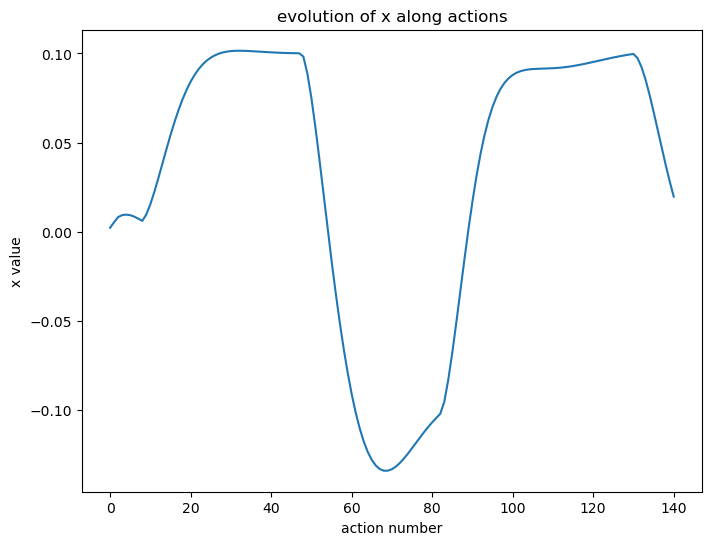

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
plt.plot(np.arange(len(xpos_list)),xpos_list)
plt.xlabel('action number')
plt.ylabel('x value')
plt.title('evolution of x along actions')
plt.show()

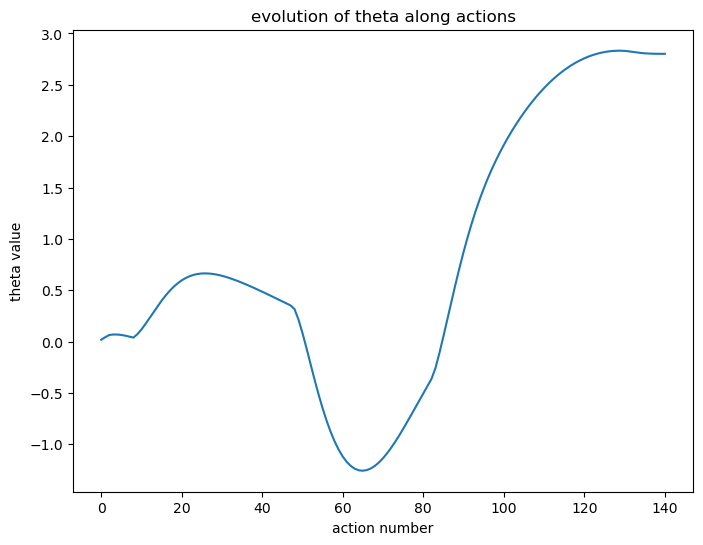

In [19]:
plt.figure(figsize=(8,6))
plt.plot(np.arange(len(theta_list)),theta_list)
plt.xlabel('action number')
plt.ylabel('theta value')
plt.title('evolution of theta along actions')
plt.show()

In [24]:
xlistbis = np.array(xpos_list[:131])
thetalistbis= np.array(theta_list[:131])
xdot_list = np.array(xdot_list)
thetadot_list = np.array(thetadot_list)

In [23]:
print(len(xdot_list))

131


In [25]:
state_D = np.vstack((xlistbis,xdot_list,thetalistbis,thetadot_list)).T

In [49]:
from scipy.optimize import minimize
# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000,swing = True)
time.sleep(2)

# Define the system dynamics
def dynamics(u):
    state, _, _ = env.step(np.clip(u,-1,1))
    time.sleep(0.05)
    return state

# Define the cost function
def cost_function(U, X_d, T):
    s = env.reset()
    cost = 0
    for k in range(T):
        u = U[k]
        x = dynamics(u)  # System dynamics
        cost += np.sum((x - X_d[k])**2) + np.sum(u**2)  # Cost terms
        
    return cost

# Define problem parameters
T = 131  # Number of timesteps
u_dim = 1  # Control dimension
X_d = state_D  # Example demonstration trajectory

U_init = np.zeros(T)  # Initial guess for control

# Solve the optimization problem
result = minimize(
    fun=cost_function, 
    x0=U_init, 
    args=(X_d,  T), 
    method='L-BFGS-B'
)

# Optimal controls
U_optimal = result.x

KeyboardInterrupt: 

In [35]:
import numpy as np
import time
from scipy.optimize import minimize

best_states =[]
# Initialize environment
env = EnvRealistic(TIME_HORIZON=1000, swing=True)
time.sleep(2)

# Define the system dynamics (no change, just call step with clipping)
def dynamics(u):
    state, _, _ = env.step(np.clip(u, -1, 1))
    time.sleep(0.05)
    return state

# Define the cost function
def cost_function_at_t(u_t, X_d, t):
    """
    Computes the cost for a given control u_t at time t, taking into account previous controls
    and previous states in the trajectory.
    """
    
    # Apply the control u_t and get the new state
    new_state = dynamics(u_t)
    
    # Compute cost: the difference between the target trajectory and the simulated state
    cost = np.sum((new_state - X_d[t+1])**2) + u_t**2  # Include control effort in cost
    return cost

# Hierarchical optimization function
def hierarchical_optimization(X_d, T):
    """
    Solves the optimal control problem in a hierarchical fashion by optimizing
    controls at each timestep t, given previous optimal controls.
    """
    U_optimal = np.zeros(T)  # Control array to store optimal controls

    
    # For each timestep, optimize the control for that timestep
    for t in tqdm(range(T)):
        # For this step, we want to minimize the cost for control u_t given previous best controls
        
        # Use a discretized search over the control range [-1, 1] with 100 steps
        u_values = np.linspace(-1, 1, 20)
        
        # Minimize the cost for the current timestep's control
        best_cost = float('inf')
        best_u = None
        
        
        for u_t in u_values:
            if t==0:
                env.reset()
            else : 
                p.restoreState(best_states[-1])
            # Minimize cost for this u_t
            cost = cost_function_at_t(u_t, X_d, t)
            
            # If the cost is better, update the best control
            if cost < best_cost:
                best_cost = cost
                best_u = u_t
                best_state = p.saveState()
        u_neighborhood = np.linspace(np.clip(best_u - 0.1, -1, 1), np.clip(best_u + 0.1, -1, 1), int(0.2 / 0.01) + 1)
        for u_t in u_neighborhood:
            if t==0:
                env.reset()
            else : 
                p.restoreState(best_states[-1])
            # Minimize cost for this u_t
            cost = cost_function_at_t(u_t, X_d, t)
            
            # If the cost is better, update the best control
            if cost < best_cost:
                best_cost = cost
                best_u = u_t
                best_state = p.saveState()
        
        # Store the best control for this timestep
        U_optimal[t] = best_u
        
        # Simulate the system with the best control and save the state for the next iteration
        best_states.append(best_state)
    
    return U_optimal

# Example problem parameters
T = 130  # Number of timesteps (for example, 131)
X_d = state_D  # Example demonstration trajectory

# Perform the hierarchical optimization
U_optimal = hierarchical_optimization(X_d, T)

# Resulting optimal controls
print("Optimal controls: ", U_optimal)


NameError: name 'start_point' is not defined

In [20]:
with open('U_opt_2_stage.txt', 'w') as file:
    for item in U_optimal:
        file.write(f"{item}\n")  # Write each item on a new line

In [ ]:
with open('U_opt_2_stage.txt', 'r') as file:
    Uopt = [float(line.strip()) for line in file]

In [42]:
env = EnvRealistic(TIME_HORIZON=1000, swing=True)
xlist_robot = []
theta_robot= []
s = env.reset()
time.sleep(2)
for u in U_optimal:

  s, dead, trunc =env.step(np.clip(1.5*u, -1, 1))
  xlist_robot.append(s[0])
  theta_robot.append(s[2])
for t in range(5):
  s, dead, trunc =env.step(np.clip(U_optimal[-1], -1, 1))
  xlist_robot.append(s[0])
  theta_robot.append(s[2])


: 

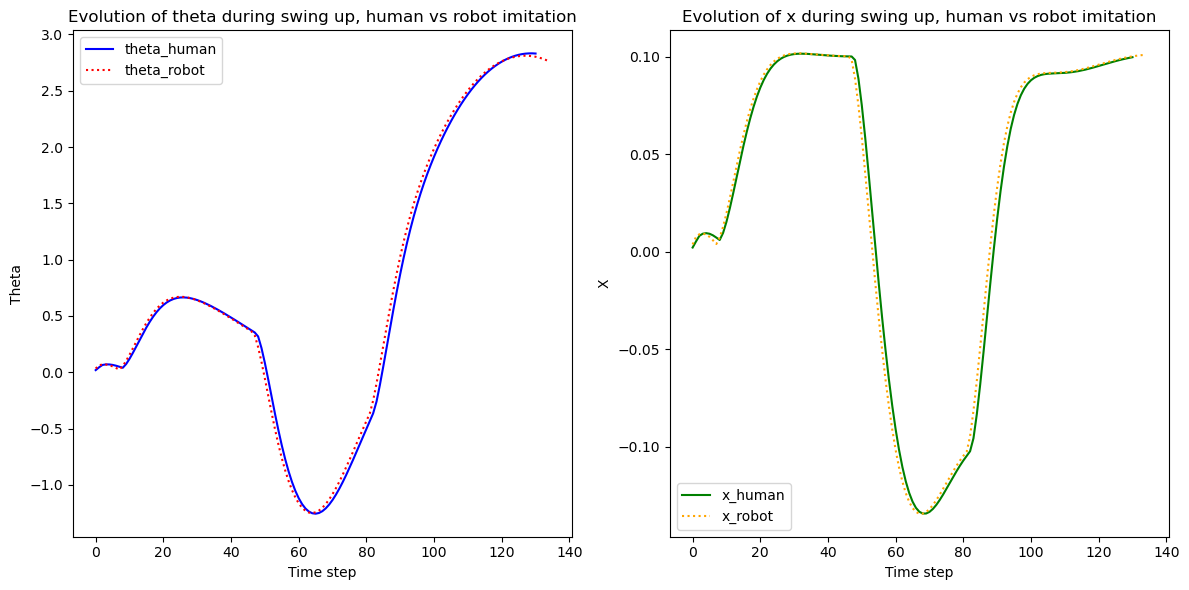

In [31]:
import matplotlib.pyplot as plt
# Create a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Left subplot: theta_listbis vs. theta_robot
ax1.plot(np.arange(len(thetalistbis)), thetalistbis, label='theta_human', linestyle='-', color='b')  # Solid line
ax1.plot(np.arange(len(theta_robot)), theta_robot, label='theta_robot', linestyle=':', color='r')  # Dotted line
ax1.set_title('Evolution of theta during swing up, human vs robot imitation')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Theta')
ax1.legend()

# Right subplot: xlistbis vs. x_robot
ax2.plot(np.arange(len(xlistbis)), xlistbis, label='x_human', linestyle='-', color='g')  # Solid line
ax2.plot(np.arange(len(xlist_robot)), xlist_robot, label='x_robot', linestyle=':', color='orange')  # Dotted line
ax2.set_title('Evolution of x during swing up, human vs robot imitation')
ax2.set_xlabel('Time step')
ax2.set_ylabel('X')
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

In [25]:
K = np.array(K)
while True:
  a = np.clip(np.dot(-K, s), -1, 1)
  print(a)
  s, dead, trunc = env.step(a)
  if dead or trunc:
    print(f"Successfull balancing for {env.timestep} timesteps")
    break

[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[-1.]
[0.29362956]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.]
[1.

KeyboardInterrupt: 

In [64]:
# Adjust camera settings to place the camera looking along the Y-axis
camera_distance = 5  # Camera distance from the target
camera_up = [0, 1, 0]  # Up vector along the Y-axis
camera_target = [0, 0, 1]  # Target the center of the environment

# The camera "eye" is positioned along the Y-axis, looking along the X or Z axis
camera_eye = [0, 5, 1]  # Camera position is 5 units along the Y-axis, at height 1

# Set the camera using resetDebugVisualizerCamera
# Arguments: (camera_distance, camera_yaw, camera_pitch, camera_target_position)
# Camera yaw = 90 degrees (rotated around the Z-axis)
# Camera pitch = -30 degrees (downward)
p.resetDebugVisualizerCamera(camera_distance, cameraYaw=90, cameraPitch=-30, cameraTargetPosition=camera_target)



In [32]:
pip install PyMuPDF Pillow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.4/18.4 MB 32.5 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [36]:
import fitz  # PyMuPDF
import math
from PIL import Image

# Define the A0 and A4 dimensions (in points at 72 DPI, since fitz works with points)
A0_width = 993.62  # in pixels at 300 DPI
A0_height = 1403.94
A4_width = 2480  # in pixels at 300 DPI
A4_height = 3508

def split_pdf_to_A4(input_pdf_path, output_folder):
    # Open the PDF
    doc = fitz.open(input_pdf_path)
    num_pages = len(doc)

    # Loop through each page in the PDF
    for page_num in range(num_pages):
        page = doc.load_page(page_num)

        # Get page dimensions in points (1 point = 1/72 inch)
        page_width = page.rect.width
        page_height = page.rect.height

        # Calculate number of A4 pages required for the width and height of the page
        num_A4_cols = math.ceil(page_width / A4_width)
        num_A4_rows = math.ceil(page_height / A4_height)

        # Loop through and create A4-sized sections of the page
        for row in range(num_A4_rows):
            for col in range(num_A4_cols):
                # Define the cropping rectangle for each A4-sized section
                x0 = col * A4_width
                y0 = row * A4_height
                x1 = min((col + 1) * A4_width, page_width)
                y1 = min((row + 1) * A4_height, page_height)

                # Crop the page to the A4 section
                pix = page.get_pixmap(clip=fitz.Rect(x0, y0, x1, y1))

                # Convert the Pixmap to a PIL Image
                img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)

                # Save the image as a PNG or PDF
                output_image_path = f"{output_folder}/page_{page_num + 1}_row_{row + 1}_col_{col + 1}.png"
                img.save(output_image_path)

    print(f"Split PDF into images and saved in {output_folder}")

# Usage
input_pdf_path = "poster_robotic_mva-2.pdf"  # Path to your A0-sized PDF
output_folder = "A4_images"  # Folder to save A4 images
split_pdf_to_A4(input_pdf_path, output_folder)


Split PDF into images and saved in A4_images


In [38]:
import fitz  # PyMuPDF
from PIL import Image
import os

# Function to convert A4 PDF to A0 and split it into 8 A4 subimages
def convert_and_split_pdf(input_pdf, output_dir):
    # Open the input PDF using PyMuPDF
    doc = fitz.open(input_pdf)
    
    # Set the A0 page size (1189mm x 841mm in points, where 1 pt = 1/72 inch)
    A0_width, A0_height = 1189 * 72 / 25.4, 841 * 72 / 25.4  # Convert mm to points
    
    # Iterate over each page in the PDF (assuming there's only one page in A4 to start)
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        
        # Resize the page content to fit A0 dimensions
        mat = fitz.Matrix(A0_width / page.rect.width, A0_height / page.rect.height)
        pix = page.get_pixmap(matrix=mat, alpha=False)
        
        # Convert the pixmap to a PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Split the image into 8 A4-sized subimages (each A4 = 297mm x 210mm)
        A4_width, A4_height = 297 * 72 / 25.4, 210 * 72 / 25.4  # Convert mm to points
        
        # Create a directory to store the output images
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Split into 8 parts (2 rows, 4 columns)
        subimages = []
        for i in range(2):
            for j in range(4):
                left = j * A4_width
                upper = i * A4_height
                right = left + A4_width
                lower = upper + A4_height

                # Crop the image to the current A4 section
                cropped_img = img.crop((left, upper, right, lower))

                # Save the cropped image as a PNG file
                output_file = os.path.join(output_dir, f"page_{page_num + 1}_part_{i * 4 + j + 1}.png")
                cropped_img.save(output_file)

                # Optionally, store in a list of subimages for later use
                subimages.append(cropped_img)

    print(f"PDF converted and split into A4 subimages in {output_dir}")

# Example usage
input_pdf = "poster_robotic_mva.pdf"  # Path to the input A4 PDF file
output_dir = "A4_images"    # Directory to save the A4 subimages
convert_and_split_pdf(input_pdf, output_dir)


PDF converted and split into A4 subimages in A4_images


In [39]:
import fitz  # PyMuPDF
from PIL import Image
import os

# Function to convert A4 PDF to A0 and split it into 16 A4 subimages
def convert_and_split_pdf(input_pdf, output_dir):
    # Open the input PDF using PyMuPDF
    doc = fitz.open(input_pdf)
    
    # Set the A0 page size (1189mm x 841mm in points, where 1 pt = 1/72 inch)
    A0_width, A0_height = 1189 * 72 / 25.4, 841 * 72 / 25.4  # Convert mm to points
    
    # Iterate over each page in the PDF (assuming there's only one page in A4 to start)
    for page_num in range(len(doc)):
        page = doc.load_page(page_num)
        
        # Resize the page content to fit A0 dimensions
        mat = fitz.Matrix(A0_width / page.rect.width, A0_height / page.rect.height)
        pix = page.get_pixmap(matrix=mat, alpha=False)
        
        # Convert the pixmap to a PIL Image
        img = Image.frombytes("RGB", [pix.width, pix.height], pix.samples)
        
        # Split the image into 16 A4-sized subimages (4 rows, 4 columns)
        A4_width, A4_height = 297 * 72 / 25.4, 210 * 72 / 25.4  # Convert mm to points
        
        # Create a directory to store the output images
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Split into 16 parts (4 rows, 4 columns)
        subimages = []
        for i in range(4):
            for j in range(4):
                left = j * A4_width
                upper = i * A4_height
                right = left + A4_width
                lower = upper + A4_height

                # Crop the image to the current A4 section
                cropped_img = img.crop((left, upper, right, lower))

                # Save the cropped image as a PNG file
                output_file = os.path.join(output_dir, f"page_{page_num + 1}_part_{i * 4 + j + 1}.png")
                cropped_img.save(output_file)

                # Optionally, store in a list of subimages for later use
                subimages.append(cropped_img)

    print(f"PDF converted and split into A4 subimages in {output_dir}")

# Example usage
input_pdf = "poster_robotic_mva.pdf"  # Path to the input A4 PDF file
output_dir = "A4_for_A0"    # Directory to save the A4 subimages
convert_and_split_pdf(input_pdf, output_dir)


PDF converted and split into A4 subimages in A4_for_A0


In [41]:
pip install pdftools.pdfposter

Note: you may need to restart the kernel to use updated packages.
